In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/Users/richardgrumitt/Documents/berkeley/NFMC_Jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import scipy
from scipy.stats import multivariate_normal as n_mvn
import corner
import torch
import warnings
import pickle

import torch.distributions
from nfmc_jax.DLA.base import PPDLMC, LatentDLA
from nfmc_jax.DLA.posterior import TorchPosterior
from nfmc_jax.DLA.debug import MultiStageDebugger
from nfmc_jax.flows.base import SINFInterface, RealNVPInterface, MAFInterface, RQNSFInterface, PPInterface
from nfmc_jax.utils.torch_distributions import gaussian_log_prob, Funnel

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)

/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# German Credit

In [2]:
data = np.genfromtxt("./fiducial_samples/german.data-numeric")
'''
x = data[:, :-1]
y = (data[:, -1] - 1).astype(np.int32)

x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)

x /= (x_max - x_min)
x = 2.0 * x - 1.0

x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
'''

x = data[:, :-1]
y = (data[:, -1] - 1).astype(np.int32)
x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)
x /= (x_max - x_min)
x = 2.0 * x - 1.0
x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)

n_dim_data = x.shape[1]
n_dim_params = 1 + n_dim_data + n_dim_data  # tau, lambdas, betas

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int32).view(-1, 1)


In [195]:
n = x.shape[0]
n_dim_data = x.shape[1]

'''
def log_like(params, data=y, covariates=x, jitter=1e-6):
    
    log_tau = params[:, 0].reshape(params.shape[0], 1)
    log_lam = params[:, 1:d+1]
    beta = params[:, d+1:]

    data = torch.broadcast_to(data.reshape(data.shape[0], 1), (data.shape[0], params.shape[0]))
    
    f = torch.matmul(covariates, (torch.exp(log_tau) * beta * torch.exp(log_lam)).T)
    
    return torch.sum(torch.distributions.Bernoulli(probs=torch.clip(torch.special.expit(f),
                                                                    min=jitter,
                                                                    max=0.999)).log_prob(data), dim=0)

def log_prior(params, jitter=1e-6):
    
    log_tau = params[:, 0]
    log_lam = params[:, 1:d+1]
    beta = params[:, d+1:]
    logp_tau = log_tau + torch.distributions.Gamma(0.5, 0.5).log_prob(torch.clip(torch.exp(log_tau),
                                                                                 min=jitter,
                                                                                 max=0.999))
    logp_lam = torch.sum(log_lam + torch.distributions.Gamma(0.5, 0.5).log_prob(torch.clip(torch.exp(log_lam),
                                                                                           min=jitter,
                                                                                           max=0.999)), dim=1)
    #logp_beta = torch.sum(torch.distributions.Normal(loc=0.0, scale=1.0).log_prob(beta), dim=1)
    logp_beta = torch.distributions.MultivariateNormal(loc=torch.zeros(d), 
                                                       covariance_matrix=torch.eye(d)).log_prob(beta)
    
    return logp_tau + logp_lam + logp_beta
'''

def gamma_log_prob(x, alpha=0.5, beta=0.5):
    # Proportional
    return (alpha - 1) * torch.log(x) - beta * x


def log_prior(params: torch.Tensor):
    # Log prior (proportional) for a single parameter sample with shape (n_dim_params, )
    tau = params[:, 0].exp()
    lambdas = params[:, 1:1 + n_dim_data].exp()
    betas = params[:, 1 + n_dim_data:]

    tau_log_prob = torch.log(tau) + gamma_log_prob(tau)
    lambdas_log_prob = (torch.log(lambdas) + gamma_log_prob(lambdas)).sum(dim=-1)
    betas_log_prob = gaussian_log_prob(betas).sum(dim=-1)

    log_prob = tau_log_prob + lambdas_log_prob + betas_log_prob
    return log_prob


def log_likelihood(params: torch.Tensor):
    # Log likelihood (proportional) for a single parameter sample with shape (n_dim_params, )
    tau = params[:, 0].exp()
    lambdas = params[:, 1:1 + n_dim_data].exp()
    betas = params[:, 1 + n_dim_data:]

    thetas = torch.clip(torch.sigmoid(x @ (tau.view(-1, 1) * betas * lambdas).T), 1e-7, 1 - 1e-7)
    log_prob = y * torch.log(thetas) + (1 - y) * torch.log(1 - thetas)
    log_prob = log_prob.sum(dim=0)
    return log_prob
    
def prior_rvs(N):
    
    tau = torch.distributions.Gamma(0.5, 0.5).sample((N,))
    lam = torch.distributions.Gamma(0.5, 0.5).sample((N, n_dim_data))
    beta = torch.randn((N, n_dim_data))
    
    return torch.cat([torch.log(tau).reshape(N, 1), torch.log(lam), beta], dim=1)

initial_samples = prior_rvs(51)

posterior = TorchPosterior(log_likelihood = lambda x: log_likelihood(x),
                           log_prior = lambda x: log_prior(x))

In [196]:
n = x.shape[0]
d = x.shape[1]

In [197]:
print(log_likelihood(initial_samples).shape)
print(log_prior(initial_samples).shape)

torch.Size([51])
torch.Size([51])


In [201]:
# Note - check about passing validation data to this.

flow_interface = SINFInterface()
flow_interface.create_flow(x=initial_samples,
                           val_frac=0.25,
                           iteration=None,
                           bounds=None,
                           alpha=(0, 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='NERCOME',
                           maxknot=False,
                           MSWD_max_iter=None)

In [202]:
burnin_interface = SINFInterface()
burnin_interface.create_flow(x=initial_samples,
                           val_frac=0.0,
                           iteration=5,
                           bounds=None,
                           alpha=(0., 0.),
                           NBfirstlayer=True,
                           verbose=False,
                           M=5,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='NERCOME',
                           maxknot=False,
                           MSWD_max_iter=None)

In [203]:
dlmc = LatentDLA(
    interface=flow_interface,
    burnin_interface=flow_interface,
    posterior=posterior,
    debugger=None
)

xf = dlmc.run(initial_samples,
              main_step=0.1,
              burnin_step=0.1,
              burnin_optimizer='adam',
              optimizer='line_search',
              optim_scheduler='identity',
              exp_decay_rate=0.99,
              cos_T_max=100,
              cos_lr_min=0.0,
              burnin_optim_steps=5,
              optim_steps=1,
              atol=1e-15,
              max_burnin=200,
              burnin_thresh=1.00,
              num_upsample=2*51-initial_samples.shape[0],
              max_iterations=1000,
         latent=True,
         IMHstep=0,
         CMHstep=0,
         CMHscale=0.1,
         ULMstep=0,
         stochastic_calibration=False,
         taylor_zeta=True,
         use_tqdm=True,
         post_ulm_steps=0,
         post_ulm_batch=0,
         animate_kwargs=dict(
             dpi=200),
         train_kwargs={'val_frac': 0.2},
         underdamped_kwargs={'step_size':1.0e-2, 'gamma': 2.0}
        )

[Stage 0] Beta: 1.0:   0%|    | 1/1200 [00:00<05:25,  3.68it/s, accept_IMH=None]

Virial = 406.57086181640625
<sum_x_virial> = 406.57086181640625


[Stage 0] Beta: 1.0:   0%|    | 2/1200 [00:00<06:19,  3.15it/s, accept_IMH=None]

Virial = 132.7912139892578
<sum_x_virial> = 132.7912139892578


[Stage 0] Beta: 1.0:   0%|    | 3/1200 [00:00<05:47,  3.44it/s, accept_IMH=None]

Virial = 64.156982421875
<sum_x_virial> = 64.156982421875


[Stage 0] Beta: 1.0:   0%|    | 4/1200 [00:01<06:22,  3.13it/s, accept_IMH=None]

Virial = 127.22672271728516
<sum_x_virial> = 127.22672271728516


[Stage 0] Beta: 1.0:   0%|    | 5/1200 [00:01<06:30,  3.06it/s, accept_IMH=None]

Virial = 85.77019500732422
<sum_x_virial> = 85.77019500732422


[Stage 0] Beta: 1.0:   0%|    | 6/1200 [00:01<06:32,  3.04it/s, accept_IMH=None]

Virial = 61.09447479248047
<sum_x_virial> = 61.09447479248047


[Stage 0] Beta: 1.0:   1%|    | 7/1200 [00:02<06:39,  2.98it/s, accept_IMH=None]

Virial = 55.47465515136719
<sum_x_virial> = 55.47465515136719


[Stage 0] Beta: 1.0:   1%|    | 8/1200 [00:02<06:32,  3.04it/s, accept_IMH=None]

Virial = 56.90202713012695
<sum_x_virial> = 56.90202713012695


[Stage 0] Beta: 1.0:   1%|    | 9/1200 [00:02<06:30,  3.05it/s, accept_IMH=None]

Virial = 55.130130767822266
<sum_x_virial> = 55.130130767822266


[Stage 0] Beta: 1.0:   1%|   | 10/1200 [00:03<06:27,  3.07it/s, accept_IMH=None]

Virial = 58.6521110534668
<sum_x_virial> = 58.6521110534668


[Stage 0] Beta: 1.0:   1%|   | 11/1200 [00:03<06:31,  3.04it/s, accept_IMH=None]

Virial = 53.846031188964844
<sum_x_virial> = 53.846031188964844


[Stage 0] Beta: 1.0:   1%|   | 12/1200 [00:03<06:27,  3.07it/s, accept_IMH=None]

Virial = 57.74898910522461
<sum_x_virial> = 57.74898910522461


[Stage 0] Beta: 1.0:   1%|   | 13/1200 [00:04<06:23,  3.10it/s, accept_IMH=None]

Virial = 54.8354606628418
<sum_x_virial> = 54.8354606628418


[Stage 0] Beta: 1.0:   1%|   | 14/1200 [00:04<06:21,  3.11it/s, accept_IMH=None]

Virial = 58.2885856628418
<sum_x_virial> = 58.2885856628418


[Stage 0] Beta: 1.0:   1%|   | 15/1200 [00:04<05:59,  3.29it/s, accept_IMH=None]

Virial = 53.021759033203125
<sum_x_virial> = 53.021759033203125


[Stage 0] Beta: 1.0:   1%|   | 16/1200 [00:05<06:04,  3.25it/s, accept_IMH=None]

Virial = 68.5601806640625
<sum_x_virial> = 68.5601806640625


[Stage 0] Beta: 1.0:   1%|   | 17/1200 [00:05<06:07,  3.22it/s, accept_IMH=None]

Virial = 54.04646301269531
<sum_x_virial> = 54.04646301269531


[Stage 0] Beta: 1.0:   2%|   | 18/1200 [00:05<06:09,  3.20it/s, accept_IMH=None]

Virial = 60.40544509887695
<sum_x_virial> = 60.40544509887695


[Stage 0] Beta: 1.0:   2%|   | 19/1200 [00:06<06:10,  3.18it/s, accept_IMH=None]

Virial = 52.72068786621094
<sum_x_virial> = 52.72068786621094


[Stage 0] Beta: 1.0:   2%|   | 20/1200 [00:06<06:19,  3.11it/s, accept_IMH=None]

Virial = 59.30915069580078
<sum_x_virial> = 59.30915069580078


[Stage 0] Beta: 1.0:   2%|   | 21/1200 [00:06<07:09,  2.74it/s, accept_IMH=None]

Virial = 49.97675704956055
<sum_x_virial> = 49.97675704956055


[Stage 0] Beta: 1.0:   2%|   | 22/1200 [00:07<06:56,  2.83it/s, accept_IMH=None]

Virial = 52.914371490478516
<sum_x_virial> = 52.914371490478516


[Stage 0] Beta: 1.0:   2%|   | 23/1200 [00:07<06:46,  2.90it/s, accept_IMH=None]

Virial = 49.0694694519043
<sum_x_virial> = 49.0694694519043


[Stage 0] Beta: 1.0:   2%|   | 24/1200 [00:07<06:37,  2.96it/s, accept_IMH=None]

Virial = 55.76317596435547
<sum_x_virial> = 55.76317596435547


[Stage 0] Beta: 1.0:   2%|   | 25/1200 [00:08<06:31,  3.00it/s, accept_IMH=None]

Virial = 48.18603515625
<sum_x_virial> = 48.18603515625


[Stage 0] Beta: 1.0:   2%|   | 26/1200 [00:08<06:37,  2.96it/s, accept_IMH=None]

Virial = 54.856231689453125
<sum_x_virial> = 54.856231689453125


[Stage 0] Beta: 1.0:   2%|   | 27/1200 [00:08<06:28,  3.02it/s, accept_IMH=None]

Virial = 48.57403564453125
<sum_x_virial> = 48.57403564453125


[Stage 0] Beta: 1.0:   2%|   | 28/1200 [00:09<06:24,  3.05it/s, accept_IMH=None]

Virial = 55.001243591308594
<sum_x_virial> = 55.001243591308594


[Stage 0] Beta: 1.0:   2%|   | 29/1200 [00:09<06:21,  3.07it/s, accept_IMH=None]

Virial = 50.373680114746094
<sum_x_virial> = 50.373680114746094


[Stage 0] Beta: 1.0:   2%|   | 30/1200 [00:09<06:16,  3.10it/s, accept_IMH=None]

Virial = 54.694908142089844
<sum_x_virial> = 54.694908142089844


[Stage 0] Beta: 1.0:   3%|   | 31/1200 [00:10<06:14,  3.12it/s, accept_IMH=None]

Virial = 48.73064041137695
<sum_x_virial> = 48.73064041137695


[Stage 0] Beta: 1.0:   3%|   | 32/1200 [00:10<06:14,  3.12it/s, accept_IMH=None]

Virial = 53.773189544677734
<sum_x_virial> = 53.773189544677734


[Stage 0] Beta: 1.0:   3%|   | 33/1200 [00:10<06:14,  3.11it/s, accept_IMH=None]

Virial = 50.19575500488281
<sum_x_virial> = 50.19575500488281


[Stage 0] Beta: 1.0:   3%|   | 34/1200 [00:11<06:17,  3.09it/s, accept_IMH=None]

Virial = 54.11261749267578
<sum_x_virial> = 54.11261749267578


[Stage 0] Beta: 1.0:   3%|   | 35/1200 [00:11<06:13,  3.12it/s, accept_IMH=None]

Virial = 49.57112121582031
<sum_x_virial> = 49.57112121582031


[Stage 0] Beta: 1.0:   3%|   | 36/1200 [00:11<06:40,  2.91it/s, accept_IMH=None]

Virial = 54.408470153808594
<sum_x_virial> = 54.408470153808594


[Stage 0] Beta: 1.0:   3%|   | 37/1200 [00:12<06:30,  2.98it/s, accept_IMH=None]

Virial = 48.60186004638672
<sum_x_virial> = 48.60186004638672


[Stage 0] Beta: 1.0:   3%|   | 38/1200 [00:12<06:22,  3.04it/s, accept_IMH=None]

Virial = 55.40848159790039
<sum_x_virial> = 55.40848159790039


[Stage 0] Beta: 1.0:   3%|   | 39/1200 [00:12<06:20,  3.05it/s, accept_IMH=None]

Virial = 50.12303161621094
<sum_x_virial> = 50.12303161621094


[Stage 0] Beta: 1.0:   3%|   | 40/1200 [00:13<06:18,  3.07it/s, accept_IMH=None]

Virial = 52.58832550048828
<sum_x_virial> = 52.58832550048828


[Stage 0] Beta: 1.0:   3%|   | 41/1200 [00:13<06:45,  2.86it/s, accept_IMH=None]

Virial = 49.095916748046875
<sum_x_virial> = 49.095916748046875


[Stage 0] Beta: 1.0:   4%|   | 42/1200 [00:13<07:05,  2.72it/s, accept_IMH=None]

Virial = 52.97550964355469
<sum_x_virial> = 52.97550964355469


[Stage 0] Beta: 1.0:   4%|   | 43/1200 [00:14<07:38,  2.52it/s, accept_IMH=None]

Virial = 46.70704650878906
<sum_x_virial> = 46.70704650878906


[Stage 0] Beta: 1.0:   4%|   | 44/1200 [00:14<07:15,  2.65it/s, accept_IMH=None]

Virial = 51.784645080566406
<sum_x_virial> = 51.784645080566406


[Stage 0] Beta: 1.0:   4%|   | 45/1200 [00:15<07:36,  2.53it/s, accept_IMH=None]

Virial = 44.29290008544922
<sum_x_virial> = 44.29290008544922


[Stage 0] Beta: 1.0:   4%|   | 46/1200 [00:15<07:08,  2.69it/s, accept_IMH=None]

Virial = 60.33369827270508
<sum_x_virial> = 60.33369827270508


[Stage 0] Beta: 1.0:   4%|   | 47/1200 [00:15<07:11,  2.67it/s, accept_IMH=None]

Virial = 42.34671401977539
<sum_x_virial> = 42.34671401977539


[Stage 0] Beta: 1.0:   4%|   | 48/1200 [00:16<07:26,  2.58it/s, accept_IMH=None]

Virial = 59.327884674072266
<sum_x_virial> = 59.327884674072266


[Stage 0] Beta: 1.0:   4%|   | 49/1200 [00:16<07:31,  2.55it/s, accept_IMH=None]

Virial = 43.52140426635742
<sum_x_virial> = 43.52140426635742


[Stage 0] Beta: 1.0:   4%|▏  | 50/1200 [00:17<07:30,  2.55it/s, accept_IMH=None]

Virial = 52.44634246826172
<sum_x_virial> = 52.44634246826172


[Stage 0] Beta: 1.0:   4%|▏  | 51/1200 [00:17<07:29,  2.55it/s, accept_IMH=None]

Virial = 44.02922058105469
<sum_x_virial> = 44.02922058105469


[Stage 0] Beta: 1.0:   4%|▏  | 52/1200 [00:17<07:55,  2.41it/s, accept_IMH=None]

Virial = 49.44991683959961
<sum_x_virial> = 49.44991683959961


[Stage 0] Beta: 1.0:   4%|▏  | 53/1200 [00:18<07:29,  2.55it/s, accept_IMH=None]

Virial = 41.98282241821289
<sum_x_virial> = 41.98282241821289


[Stage 0] Beta: 1.0:   4%|▏  | 54/1200 [00:18<07:28,  2.55it/s, accept_IMH=None]

Virial = 51.59160232543945
<sum_x_virial> = 51.59160232543945


[Stage 0] Beta: 1.0:   5%|▏  | 55/1200 [00:19<07:42,  2.48it/s, accept_IMH=None]

Virial = 46.99748229980469
<sum_x_virial> = 46.99748229980469


[Stage 0] Beta: 1.0:   5%|▏  | 56/1200 [00:19<07:42,  2.48it/s, accept_IMH=None]

Virial = 49.647613525390625
<sum_x_virial> = 49.647613525390625
Virial = 43.370216369628906
<sum_x_virial> = 43.370216369628906


[Stage 0] Beta: 1.0:   5%|▏  | 58/1200 [00:20<08:44,  2.18it/s, accept_IMH=None]

Virial = 44.33765411376953
<sum_x_virial> = 44.33765411376953


[Stage 0] Beta: 1.0:   5%|▏  | 59/1200 [00:20<08:22,  2.27it/s, accept_IMH=None]

Virial = 46.20451736450195
<sum_x_virial> = 46.20451736450195


[Stage 0] Beta: 1.0:   5%|▏  | 60/1200 [00:21<08:29,  2.24it/s, accept_IMH=None]

Virial = 45.79643630981445
<sum_x_virial> = 45.79643630981445


[Stage 0] Beta: 1.0:   5%|▏  | 61/1200 [00:21<07:42,  2.46it/s, accept_IMH=None]

Virial = 42.856170654296875
<sum_x_virial> = 42.856170654296875


[Stage 0] Beta: 1.0:   5%|▏  | 62/1200 [00:22<08:03,  2.35it/s, accept_IMH=None]

Virial = 45.8238525390625
<sum_x_virial> = 45.8238525390625


[Stage 0] Beta: 1.0:   5%|▏  | 63/1200 [00:22<07:35,  2.49it/s, accept_IMH=None]

Virial = 46.15445327758789
<sum_x_virial> = 46.15445327758789


[Stage 0] Beta: 1.0:   5%|▏  | 64/1200 [00:22<07:31,  2.52it/s, accept_IMH=None]

Virial = 43.98787307739258
<sum_x_virial> = 43.98787307739258


[Stage 0] Beta: 1.0:   5%|▏  | 65/1200 [00:23<07:27,  2.54it/s, accept_IMH=None]

Virial = 48.961692810058594
<sum_x_virial> = 48.961692810058594


[Stage 0] Beta: 1.0:   6%|▏  | 66/1200 [00:23<07:04,  2.67it/s, accept_IMH=None]

Virial = 41.08817672729492
<sum_x_virial> = 41.08817672729492


[Stage 0] Beta: 1.0:   6%|▏  | 67/1200 [00:24<07:44,  2.44it/s, accept_IMH=None]

Virial = 49.55455017089844
<sum_x_virial> = 49.55455017089844


[Stage 0] Beta: 1.0:   6%|▏  | 68/1200 [00:24<07:35,  2.49it/s, accept_IMH=None]

Virial = 43.66812515258789
<sum_x_virial> = 43.66812515258789


[Stage 0] Beta: 1.0:   6%|▏  | 69/1200 [00:24<07:30,  2.51it/s, accept_IMH=None]

Virial = 45.556861877441406
<sum_x_virial> = 45.556861877441406


[Stage 0] Beta: 1.0:   6%|▏  | 70/1200 [00:25<07:52,  2.39it/s, accept_IMH=None]

Virial = 43.21846008300781
<sum_x_virial> = 43.21846008300781


[Stage 0] Beta: 1.0:   6%|▏  | 71/1200 [00:25<07:24,  2.54it/s, accept_IMH=None]

Virial = 46.01796340942383
<sum_x_virial> = 46.01796340942383


[Stage 0] Beta: 1.0:   6%|▏  | 72/1200 [00:26<07:33,  2.49it/s, accept_IMH=None]

Virial = 46.188148498535156
<sum_x_virial> = 46.188148498535156


[Stage 0] Beta: 1.0:   6%|▏  | 73/1200 [00:26<07:17,  2.57it/s, accept_IMH=None]

Virial = 45.69753646850586
<sum_x_virial> = 45.69753646850586


[Stage 0] Beta: 1.0:   6%|▏  | 74/1200 [00:26<06:54,  2.72it/s, accept_IMH=None]

Virial = 43.48705291748047
<sum_x_virial> = 43.48705291748047


[Stage 0] Beta: 1.0:   6%|▏  | 75/1200 [00:27<07:06,  2.64it/s, accept_IMH=None]

Virial = 50.04097366333008
<sum_x_virial> = 50.04097366333008


[Stage 0] Beta: 1.0:   6%|▏  | 76/1200 [00:27<07:08,  2.62it/s, accept_IMH=None]

Virial = 43.89219665527344
<sum_x_virial> = 43.89219665527344


[Stage 0] Beta: 1.0:   6%|▏  | 77/1200 [00:27<07:20,  2.55it/s, accept_IMH=None]

Virial = 52.413448333740234
<sum_x_virial> = 52.413448333740234


[Stage 0] Beta: 1.0:   6%|▏  | 78/1200 [00:28<06:53,  2.71it/s, accept_IMH=None]

Virial = 39.64529037475586
<sum_x_virial> = 39.64529037475586


[Stage 0] Beta: 1.0:   7%|▏  | 79/1200 [00:28<07:16,  2.57it/s, accept_IMH=None]

Virial = 51.725791931152344
<sum_x_virial> = 51.725791931152344


[Stage 0] Beta: 1.0:   7%|▏  | 80/1200 [00:29<06:50,  2.73it/s, accept_IMH=None]

Virial = 43.90374755859375
<sum_x_virial> = 43.90374755859375


[Stage 0] Beta: 1.0:   7%|▏  | 81/1200 [00:29<07:29,  2.49it/s, accept_IMH=None]

Virial = 52.51094436645508
<sum_x_virial> = 52.51094436645508


[Stage 0] Beta: 1.0:   7%|▏  | 82/1200 [00:29<07:24,  2.51it/s, accept_IMH=None]

Virial = 43.356239318847656
<sum_x_virial> = 43.356239318847656


[Stage 0] Beta: 1.0:   7%|▏  | 83/1200 [00:30<07:28,  2.49it/s, accept_IMH=None]

Virial = 47.30461502075195
<sum_x_virial> = 47.30461502075195


[Stage 0] Beta: 1.0:   7%|▏  | 84/1200 [00:30<07:07,  2.61it/s, accept_IMH=None]

Virial = 41.52484130859375
<sum_x_virial> = 41.52484130859375
Virial = 48.424156188964844
<sum_x_virial> = 48.424156188964844


[Stage 0] Beta: 1.0:   7%|▏  | 86/1200 [00:31<07:57,  2.33it/s, accept_IMH=None]

Virial = 40.23398971557617
<sum_x_virial> = 40.23398971557617


[Stage 0] Beta: 1.0:   7%|▏  | 87/1200 [00:32<07:51,  2.36it/s, accept_IMH=None]

Virial = 47.35063552856445
<sum_x_virial> = 47.35063552856445


[Stage 0] Beta: 1.0:   7%|▏  | 88/1200 [00:32<07:44,  2.40it/s, accept_IMH=None]

Virial = 40.856204986572266
<sum_x_virial> = 40.856204986572266


[Stage 0] Beta: 1.0:   7%|▏  | 89/1200 [00:32<07:21,  2.52it/s, accept_IMH=None]

Virial = 47.926151275634766
<sum_x_virial> = 47.926151275634766


[Stage 0] Beta: 1.0:   8%|▏  | 90/1200 [00:33<07:31,  2.46it/s, accept_IMH=None]

Virial = 40.023765563964844
<sum_x_virial> = 40.023765563964844


[Stage 0] Beta: 1.0:   8%|▏  | 91/1200 [00:33<07:25,  2.49it/s, accept_IMH=None]

Virial = 50.57038497924805
<sum_x_virial> = 50.57038497924805


[Stage 0] Beta: 1.0:   8%|▏  | 92/1200 [00:34<07:31,  2.46it/s, accept_IMH=None]

Virial = 38.75596237182617
<sum_x_virial> = 38.75596237182617


[Stage 0] Beta: 1.0:   8%|▏  | 93/1200 [00:34<07:33,  2.44it/s, accept_IMH=None]

Virial = 52.02063751220703
<sum_x_virial> = 52.02063751220703


[Stage 0] Beta: 1.0:   8%|▏  | 94/1200 [00:34<07:59,  2.31it/s, accept_IMH=None]

Virial = 38.63825988769531
<sum_x_virial> = 38.63825988769531


[Stage 0] Beta: 1.0:   8%|▏  | 95/1200 [00:35<08:25,  2.19it/s, accept_IMH=None]

Virial = 49.97058868408203
<sum_x_virial> = 49.97058868408203


[Stage 0] Beta: 1.0:   8%|▏  | 96/1200 [00:35<07:38,  2.41it/s, accept_IMH=None]

Virial = 37.57379913330078
<sum_x_virial> = 37.57379913330078


[Stage 0] Beta: 1.0:   8%|▏  | 97/1200 [00:36<07:35,  2.42it/s, accept_IMH=None]

Virial = 49.91210174560547
<sum_x_virial> = 49.91210174560547


[Stage 0] Beta: 1.0:   8%|▏  | 98/1200 [00:36<07:55,  2.32it/s, accept_IMH=None]

Virial = 37.50397872924805
<sum_x_virial> = 37.50397872924805


[Stage 0] Beta: 1.0:   8%|▏  | 99/1200 [00:37<07:41,  2.39it/s, accept_IMH=None]

Virial = 48.588050842285156
<sum_x_virial> = 48.588050842285156


[Stage 0] Beta: 1.0:   8%|▏ | 100/1200 [00:37<07:06,  2.58it/s, accept_IMH=None]

Virial = 37.95227813720703
<sum_x_virial> = 37.95227813720703


[Stage 0] Beta: 1.0:   8%|▏ | 101/1200 [00:37<06:51,  2.67it/s, accept_IMH=None]

Virial = 49.17913818359375
<sum_x_virial> = 49.17913818359375
Virial = 44.09260940551758
<sum_x_virial> = 44.09260940551758


[Stage 0] Beta: 1.0:   9%|▏ | 103/1200 [00:38<07:22,  2.48it/s, accept_IMH=None]

Virial = 47.86945724487305
<sum_x_virial> = 47.86945724487305


[Stage 0] Beta: 1.0:   9%|▏ | 104/1200 [00:38<07:04,  2.58it/s, accept_IMH=None]

Virial = 42.328125
<sum_x_virial> = 42.328125


[Stage 0] Beta: 1.0:   9%|▏ | 105/1200 [00:39<07:31,  2.43it/s, accept_IMH=None]

Virial = 51.04993438720703
<sum_x_virial> = 51.04993438720703


[Stage 0] Beta: 1.0:   9%|▏ | 106/1200 [00:39<07:33,  2.41it/s, accept_IMH=None]

Virial = 43.676029205322266
<sum_x_virial> = 43.676029205322266


[Stage 0] Beta: 1.0:   9%|▏ | 107/1200 [00:40<07:04,  2.58it/s, accept_IMH=None]

Virial = 48.77211380004883
<sum_x_virial> = 48.77211380004883


[Stage 0] Beta: 1.0:   9%|▏ | 108/1200 [00:40<07:14,  2.52it/s, accept_IMH=None]

Virial = 43.3044548034668
<sum_x_virial> = 43.3044548034668


[Stage 0] Beta: 1.0:   9%|▏ | 109/1200 [00:40<07:14,  2.51it/s, accept_IMH=None]

Virial = 49.88277053833008
<sum_x_virial> = 49.88277053833008


[Stage 0] Beta: 1.0:   9%|▏ | 110/1200 [00:41<07:24,  2.45it/s, accept_IMH=None]

Virial = 42.924808502197266
<sum_x_virial> = 42.924808502197266


[Stage 0] Beta: 1.0:   9%|▏ | 111/1200 [00:41<07:41,  2.36it/s, accept_IMH=None]

Virial = 48.28307342529297
<sum_x_virial> = 48.28307342529297


[Stage 0] Beta: 1.0:   9%|▏ | 112/1200 [00:42<07:10,  2.53it/s, accept_IMH=None]

Virial = 41.564979553222656
<sum_x_virial> = 41.564979553222656


[Stage 0] Beta: 1.0:   9%|▏ | 113/1200 [00:42<07:16,  2.49it/s, accept_IMH=None]

Virial = 47.825538635253906
<sum_x_virial> = 47.825538635253906


[Stage 0] Beta: 1.0:  10%|▏ | 114/1200 [00:42<06:58,  2.59it/s, accept_IMH=None]

Virial = 42.20256423950195
<sum_x_virial> = 42.20256423950195


[Stage 0] Beta: 1.0:  10%|▏ | 115/1200 [00:43<07:04,  2.56it/s, accept_IMH=None]

Virial = 51.45021057128906
<sum_x_virial> = 51.45021057128906


[Stage 0] Beta: 1.0:  10%|▏ | 116/1200 [00:43<06:49,  2.65it/s, accept_IMH=None]

Virial = 45.44894027709961
<sum_x_virial> = 45.44894027709961
Virial = 51.20571517944336
<sum_x_virial> = 51.20571517944336


[Stage 0] Beta: 1.0:  10%|▏ | 118/1200 [00:44<07:35,  2.37it/s, accept_IMH=None]

Virial = 45.75163269042969
<sum_x_virial> = 45.75163269042969


[Stage 0] Beta: 1.0:  10%|▏ | 119/1200 [00:45<07:32,  2.39it/s, accept_IMH=None]

Virial = 51.55889129638672
<sum_x_virial> = 51.55889129638672


[Stage 0] Beta: 1.0:  10%|▏ | 120/1200 [00:45<07:32,  2.39it/s, accept_IMH=None]

Virial = 40.47294616699219
<sum_x_virial> = 40.47294616699219


[Stage 0] Beta: 1.0:  10%|▏ | 121/1200 [00:46<07:51,  2.29it/s, accept_IMH=None]

Virial = 51.68022155761719
<sum_x_virial> = 51.68022155761719


[Stage 0] Beta: 1.0:  10%|▏ | 122/1200 [00:46<07:43,  2.33it/s, accept_IMH=None]

Virial = 43.416255950927734
<sum_x_virial> = 43.416255950927734
Virial = 48.048099517822266
<sum_x_virial> = 48.048099517822266


[Stage 0] Beta: 1.0:  10%|▏ | 124/1200 [00:47<07:42,  2.33it/s, accept_IMH=None]

Virial = 37.586490631103516
<sum_x_virial> = 37.586490631103516


[Stage 0] Beta: 1.0:  10%|▏ | 125/1200 [00:47<07:13,  2.48it/s, accept_IMH=None]

Virial = 49.21105194091797
<sum_x_virial> = 49.21105194091797


[Stage 0] Beta: 1.0:  10%|▏ | 126/1200 [00:47<06:51,  2.61it/s, accept_IMH=None]

Virial = 40.75653839111328
<sum_x_virial> = 40.75653839111328


[Stage 0] Beta: 1.0:  11%|▏ | 127/1200 [00:48<06:29,  2.75it/s, accept_IMH=None]

Virial = 53.322696685791016
<sum_x_virial> = 53.322696685791016


[Stage 0] Beta: 1.0:  11%|▏ | 128/1200 [00:48<06:50,  2.61it/s, accept_IMH=None]

Virial = 45.42350769042969
<sum_x_virial> = 45.42350769042969


[Stage 0] Beta: 1.0:  11%|▏ | 129/1200 [00:49<06:51,  2.60it/s, accept_IMH=None]

Virial = 47.397308349609375
<sum_x_virial> = 47.397308349609375


[Stage 0] Beta: 1.0:  11%|▏ | 130/1200 [00:49<06:54,  2.58it/s, accept_IMH=None]

Virial = 41.39715576171875
<sum_x_virial> = 41.39715576171875


[Stage 0] Beta: 1.0:  11%|▏ | 131/1200 [00:49<06:37,  2.69it/s, accept_IMH=None]

Virial = 49.772239685058594
<sum_x_virial> = 49.772239685058594


[Stage 0] Beta: 1.0:  11%|▏ | 132/1200 [00:50<06:43,  2.65it/s, accept_IMH=None]

Virial = 46.52423095703125
<sum_x_virial> = 46.52423095703125


[Stage 0] Beta: 1.0:  11%|▏ | 133/1200 [00:50<06:46,  2.63it/s, accept_IMH=None]

Virial = 49.04796600341797
<sum_x_virial> = 49.04796600341797


[Stage 0] Beta: 1.0:  11%|▏ | 134/1200 [00:51<06:55,  2.57it/s, accept_IMH=None]

Virial = 45.76329803466797
<sum_x_virial> = 45.76329803466797


[Stage 0] Beta: 1.0:  11%|▏ | 135/1200 [00:51<06:55,  2.56it/s, accept_IMH=None]

Virial = 47.46577835083008
<sum_x_virial> = 47.46577835083008


[Stage 0] Beta: 1.0:  11%|▏ | 136/1200 [00:51<06:56,  2.56it/s, accept_IMH=None]

Virial = 45.376060485839844
<sum_x_virial> = 45.376060485839844


[Stage 0] Beta: 1.0:  11%|▏ | 137/1200 [00:52<06:55,  2.56it/s, accept_IMH=None]

Virial = 50.06159591674805
<sum_x_virial> = 50.06159591674805


[Stage 0] Beta: 1.0:  12%|▏ | 138/1200 [00:52<06:55,  2.56it/s, accept_IMH=None]

Virial = 41.88096237182617
<sum_x_virial> = 41.88096237182617


[Stage 0] Beta: 1.0:  12%|▏ | 139/1200 [00:53<06:58,  2.53it/s, accept_IMH=None]

Virial = 50.09244918823242
<sum_x_virial> = 50.09244918823242


[Stage 0] Beta: 1.0:  12%|▏ | 140/1200 [00:53<06:51,  2.58it/s, accept_IMH=None]

Virial = 41.03864669799805
<sum_x_virial> = 41.03864669799805
Virial = 51.45033645629883
<sum_x_virial> = 51.45033645629883


[Stage 0] Beta: 1.0:  12%|▏ | 142/1200 [00:54<08:06,  2.18it/s, accept_IMH=None]

Virial = 43.37720489501953
<sum_x_virial> = 43.37720489501953


[Stage 0] Beta: 1.0:  12%|▏ | 143/1200 [00:54<07:59,  2.21it/s, accept_IMH=None]

Virial = 47.26625061035156
<sum_x_virial> = 47.26625061035156


[Stage 0] Beta: 1.0:  12%|▏ | 144/1200 [00:55<07:45,  2.27it/s, accept_IMH=None]

Virial = 40.176029205322266
<sum_x_virial> = 40.176029205322266


[Stage 0] Beta: 1.0:  12%|▏ | 145/1200 [00:55<07:10,  2.45it/s, accept_IMH=None]

Virial = 45.1865119934082
<sum_x_virial> = 45.1865119934082


[Stage 0] Beta: 1.0:  12%|▏ | 146/1200 [00:56<07:10,  2.45it/s, accept_IMH=None]

Virial = 43.207218170166016
<sum_x_virial> = 43.207218170166016


[Stage 0] Beta: 1.0:  12%|▏ | 147/1200 [00:56<06:53,  2.54it/s, accept_IMH=None]

Virial = 48.90507888793945
<sum_x_virial> = 48.90507888793945


[Stage 0] Beta: 1.0:  12%|▏ | 148/1200 [00:56<06:59,  2.51it/s, accept_IMH=None]

Virial = 45.01019287109375
<sum_x_virial> = 45.01019287109375
Virial = 48.12925338745117
<sum_x_virial> = 48.12925338745117


[Stage 0] Beta: 1.0:  12%|▎ | 150/1200 [00:57<07:35,  2.30it/s, accept_IMH=None]

Virial = 41.40590286254883
<sum_x_virial> = 41.40590286254883


[Stage 0] Beta: 1.0:  13%|▎ | 151/1200 [00:58<07:59,  2.19it/s, accept_IMH=None]

Virial = 46.13934326171875
<sum_x_virial> = 46.13934326171875


[Stage 0] Beta: 1.0:  13%|▎ | 152/1200 [00:58<07:54,  2.21it/s, accept_IMH=None]

Virial = 39.415809631347656
<sum_x_virial> = 39.415809631347656


[Stage 0] Beta: 1.0:  13%|▎ | 153/1200 [00:59<07:43,  2.26it/s, accept_IMH=None]

Virial = 48.11683654785156
<sum_x_virial> = 48.11683654785156


[Stage 0] Beta: 1.0:  13%|▎ | 154/1200 [00:59<07:07,  2.45it/s, accept_IMH=None]

Virial = 40.94286346435547
<sum_x_virial> = 40.94286346435547


[Stage 0] Beta: 1.0:  13%|▎ | 155/1200 [00:59<06:44,  2.59it/s, accept_IMH=None]

Virial = 48.98439407348633
<sum_x_virial> = 48.98439407348633


[Stage 0] Beta: 1.0:  13%|▎ | 156/1200 [01:00<06:46,  2.57it/s, accept_IMH=None]

Virial = 42.865943908691406
<sum_x_virial> = 42.865943908691406


[Stage 0] Beta: 1.0:  13%|▎ | 157/1200 [01:00<06:37,  2.63it/s, accept_IMH=None]

Virial = 49.65761184692383
<sum_x_virial> = 49.65761184692383


[Stage 0] Beta: 1.0:  13%|▎ | 158/1200 [01:01<06:48,  2.55it/s, accept_IMH=None]

Virial = 43.25849151611328
<sum_x_virial> = 43.25849151611328


[Stage 0] Beta: 1.0:  13%|▎ | 159/1200 [01:01<06:39,  2.61it/s, accept_IMH=None]

Virial = 49.95332336425781
<sum_x_virial> = 49.95332336425781


[Stage 0] Beta: 1.0:  13%|▎ | 160/1200 [01:01<06:54,  2.51it/s, accept_IMH=None]

Virial = 42.05603790283203
<sum_x_virial> = 42.05603790283203


[Stage 0] Beta: 1.0:  13%|▎ | 161/1200 [01:02<06:31,  2.66it/s, accept_IMH=None]

Virial = 54.472373962402344
<sum_x_virial> = 54.472373962402344


[Stage 0] Beta: 1.0:  14%|▎ | 162/1200 [01:02<06:47,  2.55it/s, accept_IMH=None]

Virial = 42.39292526245117
<sum_x_virial> = 42.39292526245117


[Stage 0] Beta: 1.0:  14%|▎ | 163/1200 [01:02<06:32,  2.64it/s, accept_IMH=None]

Virial = 49.098228454589844
<sum_x_virial> = 49.098228454589844


[Stage 0] Beta: 1.0:  14%|▎ | 164/1200 [01:03<06:17,  2.74it/s, accept_IMH=None]

Virial = 43.267486572265625
<sum_x_virial> = 43.267486572265625


[Stage 0] Beta: 1.0:  14%|▎ | 165/1200 [01:03<06:36,  2.61it/s, accept_IMH=None]

Virial = 48.89099884033203
<sum_x_virial> = 48.89099884033203


[Stage 0] Beta: 1.0:  14%|▎ | 166/1200 [01:04<06:54,  2.49it/s, accept_IMH=None]

Virial = 46.223114013671875
<sum_x_virial> = 46.223114013671875


[Stage 0] Beta: 1.0:  14%|▎ | 167/1200 [01:04<07:22,  2.33it/s, accept_IMH=None]

Virial = 46.97011947631836
<sum_x_virial> = 46.97011947631836


[Stage 0] Beta: 1.0:  14%|▎ | 168/1200 [01:04<06:55,  2.48it/s, accept_IMH=None]

Virial = 44.22876739501953
<sum_x_virial> = 44.22876739501953


[Stage 0] Beta: 1.0:  14%|▎ | 169/1200 [01:05<06:34,  2.61it/s, accept_IMH=None]

Virial = 44.418582916259766
<sum_x_virial> = 44.418582916259766


[Stage 0] Beta: 1.0:  14%|▎ | 170/1200 [01:05<06:48,  2.52it/s, accept_IMH=None]

Virial = 50.075687408447266
<sum_x_virial> = 50.075687408447266


[Stage 0] Beta: 1.0:  14%|▎ | 171/1200 [01:06<06:49,  2.51it/s, accept_IMH=None]

Virial = 45.59906005859375
<sum_x_virial> = 45.59906005859375


[Stage 0] Beta: 1.0:  14%|▎ | 172/1200 [01:06<07:27,  2.30it/s, accept_IMH=None]

Virial = 46.12812042236328
<sum_x_virial> = 46.12812042236328


[Stage 0] Beta: 1.0:  14%|▎ | 173/1200 [01:07<07:24,  2.31it/s, accept_IMH=None]

Virial = 41.60051727294922
<sum_x_virial> = 41.60051727294922


[Stage 0] Beta: 1.0:  14%|▎ | 174/1200 [01:07<07:16,  2.35it/s, accept_IMH=None]

Virial = 43.0947265625
<sum_x_virial> = 43.0947265625


[Stage 0] Beta: 1.0:  15%|▎ | 175/1200 [01:07<07:09,  2.38it/s, accept_IMH=None]

Virial = 41.75465393066406
<sum_x_virial> = 41.75465393066406


[Stage 0] Beta: 1.0:  15%|▎ | 176/1200 [01:08<07:07,  2.40it/s, accept_IMH=None]

Virial = 45.92376708984375
<sum_x_virial> = 45.92376708984375


[Stage 0] Beta: 1.0:  15%|▎ | 177/1200 [01:08<07:02,  2.42it/s, accept_IMH=None]

Virial = 41.602840423583984
<sum_x_virial> = 41.602840423583984


[Stage 0] Beta: 1.0:  15%|▎ | 178/1200 [01:09<06:43,  2.53it/s, accept_IMH=None]

Virial = 45.664215087890625
<sum_x_virial> = 45.664215087890625


[Stage 0] Beta: 1.0:  15%|▎ | 179/1200 [01:09<07:14,  2.35it/s, accept_IMH=None]

Virial = 43.4924201965332
<sum_x_virial> = 43.4924201965332


[Stage 0] Beta: 1.0:  15%|▎ | 180/1200 [01:09<06:43,  2.53it/s, accept_IMH=None]

Virial = 44.14464569091797
<sum_x_virial> = 44.14464569091797


[Stage 0] Beta: 1.0:  15%|▎ | 181/1200 [01:10<06:28,  2.62it/s, accept_IMH=None]

Virial = 44.72909927368164
<sum_x_virial> = 44.72909927368164


[Stage 0] Beta: 1.0:  15%|▎ | 182/1200 [01:10<07:07,  2.38it/s, accept_IMH=None]

Virial = 48.11359405517578
<sum_x_virial> = 48.11359405517578


[Stage 0] Beta: 1.0:  15%|▎ | 183/1200 [01:11<06:58,  2.43it/s, accept_IMH=None]

Virial = 44.24047088623047
<sum_x_virial> = 44.24047088623047


[Stage 0] Beta: 1.0:  15%|▎ | 184/1200 [01:11<06:57,  2.43it/s, accept_IMH=None]

Virial = 47.53338623046875
<sum_x_virial> = 47.53338623046875


[Stage 0] Beta: 1.0:  15%|▎ | 185/1200 [01:12<07:15,  2.33it/s, accept_IMH=None]

Virial = 47.67852020263672
<sum_x_virial> = 47.67852020263672


[Stage 0] Beta: 1.0:  16%|▎ | 186/1200 [01:12<06:48,  2.48it/s, accept_IMH=None]

Virial = 40.938865661621094
<sum_x_virial> = 40.938865661621094


[Stage 0] Beta: 1.0:  16%|▎ | 187/1200 [01:12<06:25,  2.62it/s, accept_IMH=None]

Virial = 48.10893249511719
<sum_x_virial> = 48.10893249511719


[Stage 0] Beta: 1.0:  16%|▎ | 188/1200 [01:13<06:51,  2.46it/s, accept_IMH=None]

Virial = 42.40983581542969
<sum_x_virial> = 42.40983581542969


[Stage 0] Beta: 1.0:  16%|▎ | 189/1200 [01:13<06:31,  2.58it/s, accept_IMH=None]

Virial = 48.40345764160156
<sum_x_virial> = 48.40345764160156


[Stage 0] Beta: 1.0:  16%|▎ | 190/1200 [01:13<06:35,  2.55it/s, accept_IMH=None]

Virial = 40.186561584472656
<sum_x_virial> = 40.186561584472656


[Stage 0] Beta: 1.0:  16%|▎ | 191/1200 [01:14<06:13,  2.70it/s, accept_IMH=None]

Virial = 46.61610794067383
<sum_x_virial> = 46.61610794067383


[Stage 0] Beta: 1.0:  16%|▎ | 192/1200 [01:14<06:03,  2.77it/s, accept_IMH=None]

Virial = 42.370033264160156
<sum_x_virial> = 42.370033264160156


[Stage 0] Beta: 1.0:  16%|▎ | 193/1200 [01:15<06:40,  2.52it/s, accept_IMH=None]

Virial = 48.72092056274414
<sum_x_virial> = 48.72092056274414


[Stage 0] Beta: 1.0:  16%|▎ | 194/1200 [01:15<07:01,  2.38it/s, accept_IMH=None]

Virial = 41.49058151245117
<sum_x_virial> = 41.49058151245117


[Stage 0] Beta: 1.0:  16%|▎ | 195/1200 [01:15<06:34,  2.55it/s, accept_IMH=None]

Virial = 45.403568267822266
<sum_x_virial> = 45.403568267822266


[Stage 0] Beta: 1.0:  16%|▎ | 196/1200 [01:16<06:20,  2.64it/s, accept_IMH=None]

Virial = 41.47285461425781
<sum_x_virial> = 41.47285461425781


[Stage 0] Beta: 1.0:  16%|▎ | 197/1200 [01:16<06:02,  2.76it/s, accept_IMH=None]

Virial = 48.66623306274414
<sum_x_virial> = 48.66623306274414


[Stage 0] Beta: 1.0:  16%|▎ | 198/1200 [01:16<06:10,  2.70it/s, accept_IMH=None]

Virial = 44.893699645996094
<sum_x_virial> = 44.893699645996094
Virial = 48.96175765991211
<sum_x_virial> = 48.96175765991211


[Stage 0] Beta: 1.0:  17%|▎ | 199/1200 [01:17<07:26,  2.24it/s, accept_IMH=None]

Reached maximum number of burnin iterations.
Drawing 51 new particles from current q for post-burnin DLMC.


[Stage 0] Beta: 1.0:  17%|▎ | 200/1200 [01:18<07:52,  2.12it/s, accept_IMH=None]

<sum_x_virial> = 491.0187072753906
<step_counter> = 1.4901961088180542


[Stage 0] Beta: 1.0:  17%|▎ | 201/1200 [01:18<07:09,  2.33it/s, accept_IMH=None]

<sum_x_virial> = 331.10003662109375
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  17%|▎ | 202/1200 [01:18<06:42,  2.48it/s, accept_IMH=None]

<sum_x_virial> = 213.04637145996094
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  17%|▎ | 203/1200 [01:19<06:50,  2.43it/s, accept_IMH=None]

<sum_x_virial> = 140.5975341796875
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  17%|▎ | 204/1200 [01:19<06:09,  2.69it/s, accept_IMH=None]

<sum_x_virial> = 93.15583801269531
<step_counter> = 1.1470588445663452


[Stage 0] Beta: 1.0:  17%|▎ | 205/1200 [01:19<05:31,  3.00it/s, accept_IMH=None]

<sum_x_virial> = 71.56118774414062
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  17%|▎ | 206/1200 [01:19<05:18,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 61.285987854003906
<step_counter> = 1.2254902124404907


[Stage 0] Beta: 1.0:  17%|▎ | 207/1200 [01:20<05:20,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 54.32963562011719
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  17%|▎ | 208/1200 [01:20<05:21,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 48.640987396240234
<step_counter> = 1.127450942993164


[Stage 0] Beta: 1.0:  17%|▎ | 209/1200 [01:20<05:07,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 47.21533203125
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  18%|▎ | 210/1200 [01:21<04:58,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 46.11210250854492
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  18%|▎ | 211/1200 [01:21<04:51,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 44.686710357666016
<step_counter> = 1.127450942993164


[Stage 0] Beta: 1.0:  18%|▎ | 212/1200 [01:21<05:17,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 43.93079376220703
<step_counter> = 1.029411792755127


[Stage 0] Beta: 1.0:  18%|▎ | 213/1200 [01:22<05:17,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 43.367183685302734
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  18%|▎ | 214/1200 [01:22<05:04,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 43.39987564086914
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  18%|▎ | 215/1200 [01:22<05:39,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.38948440551758
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  18%|▎ | 216/1200 [01:23<05:34,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.591243743896484
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  18%|▎ | 217/1200 [01:23<05:07,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 41.827674865722656
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  18%|▎ | 218/1200 [01:23<05:29,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.51279830932617
<step_counter> = 1.1470588445663452


[Stage 0] Beta: 1.0:  18%|▎ | 219/1200 [01:24<05:16,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 41.71531677246094
<step_counter> = 1.058823585510254


[Stage 0] Beta: 1.0:  18%|▎ | 220/1200 [01:24<05:17,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.21632385253906
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  18%|▎ | 221/1200 [01:24<04:50,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 41.86214065551758
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  18%|▎ | 222/1200 [01:24<04:45,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.09538650512695
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  19%|▎ | 223/1200 [01:25<04:28,  3.64it/s, accept_IMH=None]

<sum_x_virial> = 42.20149230957031
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  19%|▎ | 224/1200 [01:25<04:57,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.4128303527832
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  19%|▍ | 225/1200 [01:25<04:50,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.0568962097168
<step_counter> = 1.058823585510254


[Stage 0] Beta: 1.0:  19%|▍ | 226/1200 [01:26<04:44,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.3770866394043
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  19%|▍ | 227/1200 [01:26<04:25,  3.66it/s, accept_IMH=None]

<sum_x_virial> = 42.256919860839844
<step_counter> = 1.0098038911819458


[Stage 0] Beta: 1.0:  19%|▍ | 228/1200 [01:26<04:42,  3.44it/s, accept_IMH=None]

<sum_x_virial> = 42.246707916259766
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  19%|▍ | 229/1200 [01:27<04:53,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.87405776977539
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  19%|▍ | 230/1200 [01:27<05:00,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.177391052246094
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  19%|▍ | 231/1200 [01:27<04:51,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.9315185546875
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  19%|▍ | 232/1200 [01:27<04:58,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 41.839805603027344
<step_counter> = 1.0196079015731812


[Stage 0] Beta: 1.0:  19%|▍ | 233/1200 [01:28<04:39,  3.46it/s, accept_IMH=None]

<sum_x_virial> = 42.90614318847656
<step_counter> = 1.0196079015731812


[Stage 0] Beta: 1.0:  20%|▍ | 234/1200 [01:28<04:38,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 41.97722625732422
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  20%|▍ | 235/1200 [01:28<04:38,  3.46it/s, accept_IMH=None]

<sum_x_virial> = 43.00230407714844
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  20%|▍ | 236/1200 [01:29<04:37,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.21864700317383
<step_counter> = 1.058823585510254


[Stage 0] Beta: 1.0:  20%|▍ | 237/1200 [01:29<04:48,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.53076171875
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  20%|▍ | 238/1200 [01:29<04:48,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.30610275268555
<step_counter> = 1.058823585510254


[Stage 0] Beta: 1.0:  20%|▍ | 239/1200 [01:30<04:48,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.234130859375
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  20%|▍ | 240/1200 [01:30<05:08,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.39570999145508
<step_counter> = 1.029411792755127


[Stage 0] Beta: 1.0:  20%|▍ | 241/1200 [01:30<04:56,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.155860900878906
<step_counter> = 1.0196079015731812


[Stage 0] Beta: 1.0:  20%|▍ | 242/1200 [01:30<05:01,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.5795783996582
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  20%|▍ | 243/1200 [01:31<04:49,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.3115234375
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  20%|▍ | 244/1200 [01:31<04:56,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.605533599853516
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  20%|▍ | 245/1200 [01:31<05:16,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.31611633300781
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  20%|▍ | 246/1200 [01:32<05:00,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.43357849121094
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  21%|▍ | 247/1200 [01:32<04:50,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.224151611328125
<step_counter> = 1.0098038911819458


[Stage 0] Beta: 1.0:  21%|▍ | 248/1200 [01:32<04:56,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.32160186767578
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  21%|▍ | 249/1200 [01:33<05:14,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.217750549316406
<step_counter> = 1.029411792755127


[Stage 0] Beta: 1.0:  21%|▍ | 250/1200 [01:33<04:59,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.28888702392578
<step_counter> = 1.029411792755127


[Stage 0] Beta: 1.0:  21%|▍ | 251/1200 [01:33<05:02,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.49753189086914
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  21%|▍ | 252/1200 [01:34<04:50,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.00188064575195
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  21%|▍ | 253/1200 [01:34<04:42,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.26384353637695
<step_counter> = 1.029411792755127


[Stage 0] Beta: 1.0:  21%|▍ | 254/1200 [01:34<04:36,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.115543365478516
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  21%|▍ | 255/1200 [01:35<05:00,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 41.985740661621094
<step_counter> = 1.127450942993164


[Stage 0] Beta: 1.0:  21%|▍ | 256/1200 [01:35<05:15,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.25526809692383
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  21%|▍ | 257/1200 [01:35<05:04,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 41.985877990722656
<step_counter> = 1.029411792755127


[Stage 0] Beta: 1.0:  22%|▍ | 258/1200 [01:35<04:36,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.28504943847656
<step_counter> = 1.029411792755127


[Stage 0] Beta: 1.0:  22%|▍ | 259/1200 [01:36<04:54,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.086212158203125
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  22%|▍ | 260/1200 [01:36<04:44,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.232086181640625
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  22%|▍ | 261/1200 [01:36<04:44,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.18164825439453
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  22%|▍ | 262/1200 [01:37<04:42,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.191898345947266
<step_counter> = 1.058823585510254


[Stage 0] Beta: 1.0:  22%|▍ | 263/1200 [01:37<04:42,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.20794677734375
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  22%|▍ | 264/1200 [01:37<05:05,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.15137481689453
<step_counter> = 1.0392156839370728


[Stage 0] Beta: 1.0:  22%|▍ | 265/1200 [01:38<05:07,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.156944274902344
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  22%|▍ | 266/1200 [01:38<04:51,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.08589172363281
<step_counter> = 1.058823585510254


[Stage 0] Beta: 1.0:  22%|▍ | 267/1200 [01:38<04:33,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 41.92879104614258
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  22%|▍ | 268/1200 [01:39<04:43,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.24480438232422
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  22%|▍ | 269/1200 [01:39<04:36,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.10258865356445
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  22%|▍ | 270/1200 [01:39<04:45,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.48311233520508
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  23%|▍ | 271/1200 [01:39<04:23,  3.52it/s, accept_IMH=None]

<sum_x_virial> = 42.05415725708008
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  23%|▍ | 272/1200 [01:40<04:21,  3.55it/s, accept_IMH=None]

<sum_x_virial> = 42.20283889770508
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  23%|▍ | 273/1200 [01:40<04:08,  3.73it/s, accept_IMH=None]

<sum_x_virial> = 42.048648834228516
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  23%|▍ | 274/1200 [01:40<04:44,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.306251525878906
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  23%|▍ | 275/1200 [01:41<04:50,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.159027099609375
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  23%|▍ | 276/1200 [01:41<04:42,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.34986114501953
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  23%|▍ | 277/1200 [01:41<04:35,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.24913787841797
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  23%|▍ | 278/1200 [01:41<04:35,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.30657196044922
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  23%|▍ | 279/1200 [01:42<04:35,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.22272872924805
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  23%|▍ | 280/1200 [01:42<05:01,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.27778244018555
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  23%|▍ | 281/1200 [01:43<05:11,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.158531188964844
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  24%|▍ | 282/1200 [01:43<04:54,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.23147964477539
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  24%|▍ | 283/1200 [01:43<05:16,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.1517219543457
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  24%|▍ | 284/1200 [01:44<05:29,  2.78it/s, accept_IMH=None]

<sum_x_virial> = 42.326385498046875
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  24%|▍ | 285/1200 [01:44<05:37,  2.72it/s, accept_IMH=None]

<sum_x_virial> = 42.28252029418945
<step_counter> = 1.058823585510254


[Stage 0] Beta: 1.0:  24%|▍ | 286/1200 [01:44<05:28,  2.79it/s, accept_IMH=None]

<sum_x_virial> = 42.28179168701172
<step_counter> = 1.0490195751190186


[Stage 0] Beta: 1.0:  24%|▍ | 287/1200 [01:45<05:40,  2.68it/s, accept_IMH=None]

<sum_x_virial> = 42.34905242919922
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  24%|▍ | 288/1200 [01:45<05:15,  2.89it/s, accept_IMH=None]

<sum_x_virial> = 42.35265350341797
<step_counter> = 1.058823585510254


[Stage 0] Beta: 1.0:  24%|▍ | 289/1200 [01:45<05:03,  3.00it/s, accept_IMH=None]

<sum_x_virial> = 42.19981002807617
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  24%|▍ | 290/1200 [01:46<05:19,  2.85it/s, accept_IMH=None]

<sum_x_virial> = 42.248104095458984
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  24%|▍ | 291/1200 [01:46<04:59,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.20656204223633
<step_counter> = 1.0686274766921997


[Stage 0] Beta: 1.0:  24%|▍ | 292/1200 [01:46<05:00,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.21967315673828
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  24%|▍ | 293/1200 [01:47<05:24,  2.80it/s, accept_IMH=None]

<sum_x_virial> = 42.22279357910156
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  24%|▍ | 294/1200 [01:47<05:28,  2.76it/s, accept_IMH=None]

<sum_x_virial> = 42.1876106262207
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  25%|▍ | 295/1200 [01:48<05:33,  2.72it/s, accept_IMH=None]

<sum_x_virial> = 42.199214935302734
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  25%|▍ | 296/1200 [01:48<05:08,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.17593002319336
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  25%|▍ | 297/1200 [01:48<05:05,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.09082794189453
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  25%|▍ | 298/1200 [01:48<05:01,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.24552536010742
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  25%|▍ | 299/1200 [01:49<04:48,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.125389099121094
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  25%|▌ | 300/1200 [01:49<05:19,  2.82it/s, accept_IMH=None]

<sum_x_virial> = 42.198448181152344
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  25%|▌ | 301/1200 [01:50<05:14,  2.86it/s, accept_IMH=None]

<sum_x_virial> = 42.15650939941406
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  25%|▌ | 302/1200 [01:50<05:08,  2.91it/s, accept_IMH=None]

<sum_x_virial> = 42.29270935058594
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  25%|▌ | 303/1200 [01:50<04:50,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.175899505615234
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  25%|▌ | 304/1200 [01:50<04:54,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.21865463256836
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  25%|▌ | 305/1200 [01:51<04:41,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.172264099121094
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  26%|▌ | 306/1200 [01:51<04:34,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.17066192626953
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  26%|▌ | 307/1200 [01:51<04:28,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.173072814941406
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  26%|▌ | 308/1200 [01:52<04:43,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.11199951171875
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  26%|▌ | 309/1200 [01:52<04:36,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.18940353393555
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  26%|▌ | 310/1200 [01:52<04:42,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.139556884765625
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  26%|▌ | 311/1200 [01:53<04:31,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.280860900878906
<step_counter> = 1.0882352590560913


[Stage 0] Beta: 1.0:  26%|▌ | 312/1200 [01:53<04:30,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.178367614746094
<step_counter> = 1.0784313678741455


[Stage 0] Beta: 1.0:  26%|▌ | 313/1200 [01:53<04:26,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.2187614440918
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  26%|▌ | 314/1200 [01:54<04:39,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.126914978027344
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  26%|▌ | 315/1200 [01:54<04:43,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.14454650878906
<step_counter> = 1.156862735748291


[Stage 0] Beta: 1.0:  26%|▌ | 316/1200 [01:54<04:37,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.10984420776367
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  26%|▌ | 317/1200 [01:55<05:11,  2.84it/s, accept_IMH=None]

<sum_x_virial> = 42.11524200439453
<step_counter> = 1.127450942993164


[Stage 0] Beta: 1.0:  26%|▌ | 318/1200 [01:55<04:52,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.14272689819336
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  27%|▌ | 319/1200 [01:55<05:36,  2.62it/s, accept_IMH=None]

<sum_x_virial> = 42.11375427246094
<step_counter> = 1.156862735748291


[Stage 0] Beta: 1.0:  27%|▌ | 320/1200 [01:56<05:46,  2.54it/s, accept_IMH=None]

<sum_x_virial> = 42.12565231323242
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  27%|▌ | 321/1200 [01:56<06:08,  2.39it/s, accept_IMH=None]

<sum_x_virial> = 42.17344284057617
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  27%|▌ | 322/1200 [01:57<05:30,  2.65it/s, accept_IMH=None]

<sum_x_virial> = 42.24088668823242
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  27%|▌ | 323/1200 [01:57<05:04,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.14834976196289
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  27%|▌ | 324/1200 [01:57<04:45,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.197975158691406
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  27%|▌ | 325/1200 [01:57<04:32,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.07502365112305
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  27%|▌ | 326/1200 [01:58<04:36,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.10725021362305
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  27%|▌ | 327/1200 [01:58<04:26,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.137451171875
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  27%|▌ | 328/1200 [01:58<04:19,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.09147262573242
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  27%|▌ | 329/1200 [01:59<04:27,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.15675354003906
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  28%|▌ | 330/1200 [01:59<04:45,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.15895080566406
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  28%|▌ | 331/1200 [01:59<04:32,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.14314270019531
<step_counter> = 1.1176470518112183


[Stage 0] Beta: 1.0:  28%|▌ | 332/1200 [02:00<04:29,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05698776245117
<step_counter> = 1.0980392694473267


[Stage 0] Beta: 1.0:  28%|▌ | 333/1200 [02:00<05:06,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.11708068847656
<step_counter> = 1.156862735748291


[Stage 0] Beta: 1.0:  28%|▌ | 334/1200 [02:00<04:51,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.09303283691406
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  28%|▌ | 335/1200 [02:01<04:48,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.14762496948242
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  28%|▌ | 336/1200 [02:01<04:21,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.046348571777344
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  28%|▌ | 337/1200 [02:01<04:47,  3.00it/s, accept_IMH=None]

<sum_x_virial> = 42.1228141784668
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  28%|▌ | 338/1200 [02:02<04:45,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.073570251464844
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  28%|▌ | 339/1200 [02:02<04:56,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.0976448059082
<step_counter> = 1.1470588445663452


[Stage 0] Beta: 1.0:  28%|▌ | 340/1200 [02:02<04:39,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.11741638183594
<step_counter> = 1.127450942993164


[Stage 0] Beta: 1.0:  28%|▌ | 341/1200 [02:03<05:05,  2.81it/s, accept_IMH=None]

<sum_x_virial> = 42.08538055419922
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  28%|▌ | 342/1200 [02:03<04:46,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.132144927978516
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  29%|▌ | 343/1200 [02:03<04:19,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.08692932128906
<step_counter> = 1.1470588445663452


[Stage 0] Beta: 1.0:  29%|▌ | 344/1200 [02:03<04:13,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.113258361816406
<step_counter> = 1.1078431606292725


[Stage 0] Beta: 1.0:  29%|▌ | 345/1200 [02:04<04:08,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.0888671875
<step_counter> = 1.1666666269302368


[Stage 0] Beta: 1.0:  29%|▌ | 346/1200 [02:04<04:05,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.053314208984375
<step_counter> = 1.1470588445663452


[Stage 0] Beta: 1.0:  29%|▌ | 347/1200 [02:04<04:16,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.14246368408203
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  29%|▌ | 348/1200 [02:05<04:10,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.063297271728516
<step_counter> = 1.127450942993164


[Stage 0] Beta: 1.0:  29%|▌ | 349/1200 [02:05<04:06,  3.45it/s, accept_IMH=None]

<sum_x_virial> = 42.16331100463867
<step_counter> = 1.1764706373214722


[Stage 0] Beta: 1.0:  29%|▌ | 350/1200 [02:05<04:17,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.033653259277344
<step_counter> = 1.1470588445663452


[Stage 0] Beta: 1.0:  29%|▌ | 351/1200 [02:06<04:36,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.116355895996094
<step_counter> = 1.1372549533843994


[Stage 0] Beta: 1.0:  29%|▌ | 352/1200 [02:06<04:25,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.10630416870117
<step_counter> = 1.1764706373214722


[Stage 0] Beta: 1.0:  29%|▌ | 353/1200 [02:06<04:53,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.14140319824219
<step_counter> = 1.156862735748291


[Stage 0] Beta: 1.0:  30%|▌ | 354/1200 [02:07<04:49,  2.92it/s, accept_IMH=None]

<sum_x_virial> = 42.129112243652344
<step_counter> = 1.1764706373214722


[Stage 0] Beta: 1.0:  30%|▌ | 355/1200 [02:07<04:46,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.09741973876953
<step_counter> = 1.1666666269302368


[Stage 0] Beta: 1.0:  30%|▌ | 356/1200 [02:07<04:30,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.0971794128418
<step_counter> = 1.1666666269302368


[Stage 0] Beta: 1.0:  30%|▌ | 357/1200 [02:08<04:20,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.119842529296875
<step_counter> = 1.186274528503418


[Stage 0] Beta: 1.0:  30%|▌ | 358/1200 [02:08<04:39,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.072547912597656
<step_counter> = 1.1764706373214722


[Stage 0] Beta: 1.0:  30%|▌ | 359/1200 [02:08<04:25,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.070613861083984
<step_counter> = 1.1960784196853638


[Stage 0] Beta: 1.0:  30%|▌ | 360/1200 [02:09<04:15,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.09101486206055
<step_counter> = 1.2058823108673096


[Stage 0] Beta: 1.0:  30%|▌ | 361/1200 [02:09<04:21,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.07902908325195
<step_counter> = 1.2254902124404907


[Stage 0] Beta: 1.0:  30%|▌ | 362/1200 [02:09<04:27,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.09991455078125
<step_counter> = 1.186274528503418


[Stage 0] Beta: 1.0:  30%|▌ | 363/1200 [02:09<04:17,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.06568908691406
<step_counter> = 1.186274528503418


[Stage 0] Beta: 1.0:  30%|▌ | 364/1200 [02:10<04:12,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.077880859375
<step_counter> = 1.1960784196853638


[Stage 0] Beta: 1.0:  30%|▌ | 365/1200 [02:10<04:09,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.0811653137207
<step_counter> = 1.2254902124404907


[Stage 0] Beta: 1.0:  30%|▌ | 366/1200 [02:10<04:20,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.07881164550781
<step_counter> = 1.2058823108673096


[Stage 0] Beta: 1.0:  31%|▌ | 367/1200 [02:11<04:12,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.076717376708984
<step_counter> = 1.2352941036224365


[Stage 0] Beta: 1.0:  31%|▌ | 368/1200 [02:11<04:05,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.105873107910156
<step_counter> = 1.2058823108673096


[Stage 0] Beta: 1.0:  31%|▌ | 369/1200 [02:11<04:01,  3.45it/s, accept_IMH=None]

<sum_x_virial> = 42.069618225097656
<step_counter> = 1.1960784196853638


[Stage 0] Beta: 1.0:  31%|▌ | 370/1200 [02:12<03:58,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.092403411865234
<step_counter> = 1.2450979948043823


[Stage 0] Beta: 1.0:  31%|▌ | 371/1200 [02:12<03:56,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.0645637512207
<step_counter> = 1.2549020051956177


[Stage 0] Beta: 1.0:  31%|▌ | 372/1200 [02:12<04:05,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.06610107421875
<step_counter> = 1.2549020051956177


[Stage 0] Beta: 1.0:  31%|▌ | 373/1200 [02:13<04:30,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.054874420166016
<step_counter> = 1.215686321258545


[Stage 0] Beta: 1.0:  31%|▌ | 374/1200 [02:13<04:21,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.04034423828125
<step_counter> = 1.2549020051956177


[Stage 0] Beta: 1.0:  31%|▋ | 375/1200 [02:13<04:00,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.06897735595703
<step_counter> = 1.2941176891326904


[Stage 0] Beta: 1.0:  31%|▋ | 376/1200 [02:14<05:39,  2.43it/s, accept_IMH=None]

<sum_x_virial> = 42.062950134277344
<step_counter> = 1.313725471496582


[Stage 0] Beta: 1.0:  31%|▋ | 377/1200 [02:14<05:11,  2.65it/s, accept_IMH=None]

<sum_x_virial> = 42.07809829711914
<step_counter> = 1.2647058963775635


[Stage 0] Beta: 1.0:  32%|▋ | 378/1200 [02:14<05:25,  2.52it/s, accept_IMH=None]

<sum_x_virial> = 42.05728530883789
<step_counter> = 1.313725471496582


[Stage 0] Beta: 1.0:  32%|▋ | 379/1200 [02:15<05:21,  2.56it/s, accept_IMH=None]

<sum_x_virial> = 42.05641555786133
<step_counter> = 1.2941176891326904


[Stage 0] Beta: 1.0:  32%|▋ | 380/1200 [02:15<05:07,  2.67it/s, accept_IMH=None]

<sum_x_virial> = 42.0621337890625
<step_counter> = 1.3333333730697632


[Stage 0] Beta: 1.0:  32%|▋ | 381/1200 [02:15<04:44,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.08039855957031
<step_counter> = 1.313725471496582


[Stage 0] Beta: 1.0:  32%|▋ | 382/1200 [02:16<04:33,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.06878662109375
<step_counter> = 1.3333333730697632


[Stage 0] Beta: 1.0:  32%|▋ | 383/1200 [02:16<04:23,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.06071472167969
<step_counter> = 1.3529411554336548


[Stage 0] Beta: 1.0:  32%|▋ | 384/1200 [02:16<04:14,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.0620231628418
<step_counter> = 1.3333333730697632


[Stage 0] Beta: 1.0:  32%|▋ | 385/1200 [02:17<04:11,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.053382873535156
<step_counter> = 1.3529411554336548


[Stage 0] Beta: 1.0:  32%|▋ | 386/1200 [02:17<04:17,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05609130859375
<step_counter> = 1.3921568393707275


[Stage 0] Beta: 1.0:  32%|▋ | 387/1200 [02:17<04:37,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.05899429321289
<step_counter> = 1.3333333730697632


[Stage 0] Beta: 1.0:  32%|▋ | 388/1200 [02:18<04:23,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.055381774902344
<step_counter> = 1.4607843160629272


[Stage 0] Beta: 1.0:  32%|▋ | 389/1200 [02:18<04:16,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.056129455566406
<step_counter> = 1.4019607305526733


[Stage 0] Beta: 1.0:  32%|▋ | 390/1200 [02:18<04:11,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05421829223633
<step_counter> = 1.4019607305526733


[Stage 0] Beta: 1.0:  33%|▋ | 391/1200 [02:19<04:16,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05011749267578
<step_counter> = 1.4313725233078003


[Stage 0] Beta: 1.0:  33%|▋ | 392/1200 [02:19<04:07,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05200958251953
<step_counter> = 1.470588207244873


[Stage 0] Beta: 1.0:  33%|▋ | 393/1200 [02:19<04:14,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.05119705200195
<step_counter> = 1.4117647409439087


[Stage 0] Beta: 1.0:  33%|▋ | 394/1200 [02:20<04:11,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.05451202392578
<step_counter> = 1.4509804248809814


[Stage 0] Beta: 1.0:  33%|▋ | 395/1200 [02:20<04:08,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.054054260253906
<step_counter> = 1.441176414489746


[Stage 0] Beta: 1.0:  33%|▋ | 396/1200 [02:20<04:07,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.05417251586914
<step_counter> = 1.470588207244873


[Stage 0] Beta: 1.0:  33%|▋ | 397/1200 [02:20<04:19,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.0548210144043
<step_counter> = 1.5


[Stage 0] Beta: 1.0:  33%|▋ | 398/1200 [02:21<04:22,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.05509567260742
<step_counter> = 1.5098038911819458


[Stage 0] Beta: 1.0:  33%|▋ | 399/1200 [02:21<04:12,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.05524826049805
<step_counter> = 1.5490195751190186


[Stage 0] Beta: 1.0:  33%|▋ | 400/1200 [02:21<04:27,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.05485534667969
<step_counter> = 1.5098038911819458


[Stage 0] Beta: 1.0:  33%|▋ | 401/1200 [02:22<04:16,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05557632446289
<step_counter> = 1.5882352590560913


[Stage 0] Beta: 1.0:  34%|▋ | 402/1200 [02:22<04:43,  2.82it/s, accept_IMH=None]

<sum_x_virial> = 42.05593490600586
<step_counter> = 1.5098038911819458


[Stage 0] Beta: 1.0:  34%|▋ | 403/1200 [02:23<04:38,  2.86it/s, accept_IMH=None]

<sum_x_virial> = 42.05679702758789
<step_counter> = 1.5784313678741455


[Stage 0] Beta: 1.0:  34%|▋ | 404/1200 [02:23<04:23,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05680847167969
<step_counter> = 1.627450942993164


[Stage 0] Beta: 1.0:  34%|▋ | 405/1200 [02:23<04:12,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.056514739990234
<step_counter> = 1.627450942993164


[Stage 0] Beta: 1.0:  34%|▋ | 406/1200 [02:23<04:05,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.6372549533843994


[Stage 0] Beta: 1.0:  34%|▋ | 407/1200 [02:24<03:59,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.056610107421875
<step_counter> = 1.6372549533843994


[Stage 0] Beta: 1.0:  34%|▋ | 408/1200 [02:24<03:55,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.05656051635742
<step_counter> = 1.7254902124404907


[Stage 0] Beta: 1.0:  34%|▋ | 409/1200 [02:24<03:53,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.05635452270508
<step_counter> = 1.686274528503418


[Stage 0] Beta: 1.0:  34%|▋ | 410/1200 [02:25<03:52,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05636215209961
<step_counter> = 1.7745097875595093


[Stage 0] Beta: 1.0:  34%|▋ | 411/1200 [02:25<04:38,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.6764706373214722


[Stage 0] Beta: 1.0:  34%|▋ | 412/1200 [02:25<04:27,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.05643844604492
<step_counter> = 1.7745097875595093


[Stage 0] Beta: 1.0:  34%|▋ | 413/1200 [02:26<04:27,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  34%|▋ | 414/1200 [02:26<04:39,  2.81it/s, accept_IMH=None]

<sum_x_virial> = 42.05647659301758
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  35%|▋ | 415/1200 [02:26<04:11,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05651092529297
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  35%|▋ | 416/1200 [02:27<04:27,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.056488037109375
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  35%|▋ | 417/1200 [02:27<04:16,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.05646896362305
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  35%|▋ | 418/1200 [02:27<04:07,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05647277832031
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  35%|▋ | 419/1200 [02:28<04:36,  2.82it/s, accept_IMH=None]

<sum_x_virial> = 42.05646896362305
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  35%|▋ | 420/1200 [02:28<04:33,  2.85it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  35%|▋ | 421/1200 [02:28<04:21,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.056461334228516
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  35%|▋ | 422/1200 [02:29<04:27,  2.91it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  35%|▋ | 423/1200 [02:29<04:26,  2.91it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  35%|▋ | 424/1200 [02:29<04:04,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.056480407714844
<step_counter> = 1.9509804248809814


[Stage 0] Beta: 1.0:  35%|▋ | 425/1200 [02:30<04:13,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.056480407714844
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  36%|▋ | 426/1200 [02:30<04:15,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.056480407714844
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  36%|▋ | 427/1200 [02:30<03:54,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  36%|▋ | 428/1200 [02:31<03:52,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  36%|▋ | 429/1200 [02:31<03:49,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  36%|▋ | 430/1200 [02:31<03:49,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  36%|▋ | 431/1200 [02:31<03:49,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  36%|▋ | 432/1200 [02:32<04:12,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05647277832031
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  36%|▋ | 433/1200 [02:32<04:18,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.05648422241211
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  36%|▋ | 434/1200 [02:33<04:43,  2.70it/s, accept_IMH=None]

<sum_x_virial> = 42.05648422241211
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  36%|▋ | 435/1200 [02:33<05:19,  2.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05650329589844
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  36%|▋ | 436/1200 [02:34<04:50,  2.63it/s, accept_IMH=None]

<sum_x_virial> = 42.05649185180664
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  36%|▋ | 437/1200 [02:34<04:31,  2.81it/s, accept_IMH=None]

<sum_x_virial> = 42.056488037109375
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  36%|▋ | 438/1200 [02:34<04:19,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.056488037109375
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  37%|▋ | 439/1200 [02:34<03:58,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056488037109375
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  37%|▋ | 440/1200 [02:35<04:23,  2.89it/s, accept_IMH=None]

<sum_x_virial> = 42.056480407714844
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  37%|▋ | 441/1200 [02:35<04:43,  2.68it/s, accept_IMH=None]

<sum_x_virial> = 42.05647277832031
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  37%|▋ | 442/1200 [02:36<04:24,  2.86it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  37%|▋ | 443/1200 [02:36<04:16,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.05644226074219
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  37%|▋ | 444/1200 [02:36<04:14,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.05644989013672
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  37%|▋ | 445/1200 [02:36<04:15,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  37%|▋ | 446/1200 [02:37<04:09,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  37%|▋ | 447/1200 [02:37<04:16,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.056461334228516
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  37%|▋ | 448/1200 [02:38<04:24,  2.84it/s, accept_IMH=None]

<sum_x_virial> = 42.056453704833984
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  37%|▋ | 449/1200 [02:38<04:28,  2.80it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  38%|▊ | 450/1200 [02:38<04:31,  2.76it/s, accept_IMH=None]

<sum_x_virial> = 42.056453704833984
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  38%|▊ | 451/1200 [02:39<04:17,  2.91it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  38%|▊ | 452/1200 [02:39<04:03,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  38%|▊ | 453/1200 [02:39<04:31,  2.75it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  38%|▊ | 454/1200 [02:40<04:31,  2.74it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  38%|▊ | 455/1200 [02:40<04:16,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  38%|▊ | 456/1200 [02:40<04:05,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05644989013672
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  38%|▊ | 457/1200 [02:41<05:10,  2.39it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  38%|▊ | 458/1200 [02:41<05:13,  2.37it/s, accept_IMH=None]

<sum_x_virial> = 42.056427001953125
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  38%|▊ | 459/1200 [02:42<05:10,  2.38it/s, accept_IMH=None]

<sum_x_virial> = 42.05643844604492
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  38%|▊ | 460/1200 [02:42<04:42,  2.62it/s, accept_IMH=None]

<sum_x_virial> = 42.056434631347656
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  38%|▊ | 461/1200 [02:42<04:25,  2.78it/s, accept_IMH=None]

<sum_x_virial> = 42.056434631347656
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  38%|▊ | 462/1200 [02:43<04:10,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  39%|▊ | 463/1200 [02:43<04:04,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  39%|▊ | 464/1200 [02:43<04:33,  2.69it/s, accept_IMH=None]

<sum_x_virial> = 42.056434631347656
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  39%|▊ | 465/1200 [02:44<04:05,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.056419372558594
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  39%|▊ | 466/1200 [02:44<03:59,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.056419372558594
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  39%|▊ | 467/1200 [02:44<03:50,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.05641555786133
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  39%|▊ | 468/1200 [02:45<03:57,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  39%|▊ | 469/1200 [02:45<03:53,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  39%|▊ | 470/1200 [02:45<03:59,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.05643081665039
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  39%|▊ | 471/1200 [02:46<03:54,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  39%|▊ | 472/1200 [02:46<04:13,  2.87it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  39%|▊ | 473/1200 [02:46<04:01,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.056400299072266
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  40%|▊ | 474/1200 [02:47<03:43,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  40%|▊ | 475/1200 [02:47<04:06,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.056396484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  40%|▊ | 476/1200 [02:47<04:07,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.056419372558594
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  40%|▊ | 477/1200 [02:48<04:00,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.05643081665039
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  40%|▊ | 478/1200 [02:48<03:42,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.056427001953125
<step_counter> = 1.9509804248809814


[Stage 0] Beta: 1.0:  40%|▊ | 479/1200 [02:48<04:20,  2.77it/s, accept_IMH=None]

<sum_x_virial> = 42.05643081665039
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  40%|▊ | 480/1200 [02:49<04:02,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  40%|▊ | 481/1200 [02:49<03:56,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  40%|▊ | 482/1200 [02:49<03:50,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  40%|▊ | 483/1200 [02:50<03:50,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05644989013672
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  40%|▊ | 484/1200 [02:50<03:34,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.056453704833984
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  40%|▊ | 485/1200 [02:50<03:46,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.056453704833984
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  40%|▊ | 486/1200 [02:51<03:51,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  41%|▊ | 487/1200 [02:51<03:45,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  41%|▊ | 488/1200 [02:51<04:03,  2.92it/s, accept_IMH=None]

<sum_x_virial> = 42.05644226074219
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  41%|▊ | 489/1200 [02:52<04:18,  2.75it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  41%|▊ | 490/1200 [02:52<04:12,  2.81it/s, accept_IMH=None]

<sum_x_virial> = 42.05644226074219
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  41%|▊ | 491/1200 [02:52<03:55,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.056434631347656
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  41%|▊ | 492/1200 [02:53<03:55,  3.00it/s, accept_IMH=None]

<sum_x_virial> = 42.05643844604492
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  41%|▊ | 493/1200 [02:53<03:44,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.05644226074219
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  41%|▊ | 494/1200 [02:53<03:37,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.056434631347656
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  41%|▊ | 495/1200 [02:53<03:34,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.056434631347656
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  41%|▊ | 496/1200 [02:54<03:31,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  41%|▊ | 497/1200 [02:54<03:18,  3.55it/s, accept_IMH=None]

<sum_x_virial> = 42.056427001953125
<step_counter> = 1.970588207244873


[Stage 0] Beta: 1.0:  42%|▊ | 498/1200 [02:54<03:18,  3.54it/s, accept_IMH=None]

<sum_x_virial> = 42.056427001953125
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  42%|▊ | 499/1200 [02:55<03:28,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.056427001953125
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  42%|▊ | 500/1200 [02:55<03:39,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056434631347656
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  42%|▊ | 501/1200 [02:55<03:32,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.05643081665039
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  42%|▊ | 502/1200 [02:56<03:42,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05644226074219
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  42%|▊ | 503/1200 [02:56<03:35,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.05643844604492
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  42%|▊ | 504/1200 [02:56<03:49,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.05644607543945
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  42%|▊ | 505/1200 [02:57<04:00,  2.89it/s, accept_IMH=None]

<sum_x_virial> = 42.05647659301758
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  42%|▊ | 506/1200 [02:57<03:50,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  42%|▊ | 507/1200 [02:57<04:00,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  42%|▊ | 508/1200 [02:58<04:07,  2.79it/s, accept_IMH=None]

<sum_x_virial> = 42.05647277832031
<step_counter> = 1.7450979948043823


[Stage 0] Beta: 1.0:  42%|▊ | 509/1200 [02:58<04:02,  2.85it/s, accept_IMH=None]

<sum_x_virial> = 42.056488037109375
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  42%|▊ | 510/1200 [02:58<03:52,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.056495666503906
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  43%|▊ | 511/1200 [02:59<03:54,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.056480407714844
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  43%|▊ | 512/1200 [02:59<03:42,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05648422241211
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  43%|▊ | 513/1200 [02:59<03:35,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.05649185180664
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  43%|▊ | 514/1200 [03:00<03:33,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05650329589844
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  43%|▊ | 515/1200 [03:00<03:42,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.056495666503906
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  43%|▊ | 516/1200 [03:00<03:32,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.056480407714844
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  43%|▊ | 517/1200 [03:01<03:50,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.05647277832031
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  43%|▊ | 518/1200 [03:01<03:48,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  43%|▊ | 519/1200 [03:01<03:38,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  43%|▊ | 520/1200 [03:01<03:31,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05646896362305
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  43%|▊ | 521/1200 [03:02<03:14,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  44%|▊ | 522/1200 [03:02<03:13,  3.50it/s, accept_IMH=None]

<sum_x_virial> = 42.056461334228516
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  44%|▊ | 523/1200 [03:02<03:14,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.056461334228516
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  44%|▊ | 524/1200 [03:03<03:14,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  44%|▉ | 525/1200 [03:03<03:03,  3.68it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  44%|▉ | 526/1200 [03:03<03:07,  3.60it/s, accept_IMH=None]

<sum_x_virial> = 42.05646514892578
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  44%|▉ | 527/1200 [03:03<03:10,  3.54it/s, accept_IMH=None]

<sum_x_virial> = 42.05645751953125
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  44%|▉ | 528/1200 [03:04<03:25,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.05644989013672
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  44%|▉ | 529/1200 [03:04<03:25,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05644989013672
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  44%|▉ | 530/1200 [03:04<03:24,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.056453704833984
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  44%|▉ | 531/1200 [03:05<04:05,  2.73it/s, accept_IMH=None]

<sum_x_virial> = 42.056453704833984
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  44%|▉ | 532/1200 [03:05<04:20,  2.57it/s, accept_IMH=None]

<sum_x_virial> = 42.05644226074219
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  44%|▉ | 533/1200 [03:06<03:59,  2.78it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  44%|▉ | 534/1200 [03:06<03:45,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  45%|▉ | 535/1200 [03:06<03:35,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.0564079284668
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  45%|▉ | 536/1200 [03:06<03:16,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  45%|▉ | 537/1200 [03:07<03:15,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  45%|▉ | 538/1200 [03:07<03:34,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.056400299072266
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  45%|▉ | 539/1200 [03:07<03:40,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  45%|▉ | 540/1200 [03:08<03:42,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.056427001953125
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  45%|▉ | 541/1200 [03:08<03:31,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05643081665039
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  45%|▉ | 542/1200 [03:09<04:06,  2.67it/s, accept_IMH=None]

<sum_x_virial> = 42.05642318725586
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  45%|▉ | 543/1200 [03:09<03:47,  2.89it/s, accept_IMH=None]

<sum_x_virial> = 42.05641555786133
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  45%|▉ | 544/1200 [03:09<04:03,  2.69it/s, accept_IMH=None]

<sum_x_virial> = 42.05641174316406
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  45%|▉ | 545/1200 [03:10<03:57,  2.76it/s, accept_IMH=None]

<sum_x_virial> = 42.056427001953125
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  46%|▉ | 546/1200 [03:10<03:55,  2.78it/s, accept_IMH=None]

<sum_x_virial> = 42.056427001953125
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  46%|▉ | 547/1200 [03:10<03:52,  2.81it/s, accept_IMH=None]

<sum_x_virial> = 42.056419372558594
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  46%|▉ | 548/1200 [03:11<03:38,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  46%|▉ | 549/1200 [03:11<03:27,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.056419372558594
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  46%|▉ | 550/1200 [03:11<03:31,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.05641174316406
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  46%|▉ | 551/1200 [03:12<03:26,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  46%|▉ | 552/1200 [03:12<03:31,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  46%|▉ | 553/1200 [03:12<03:33,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.0564079284668
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  46%|▉ | 554/1200 [03:12<03:15,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.056400299072266
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  46%|▉ | 555/1200 [03:13<03:31,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.056396484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  46%|▉ | 556/1200 [03:13<03:34,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.05638885498047
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  46%|▉ | 557/1200 [03:14<03:26,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.05638885498047
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  46%|▉ | 558/1200 [03:14<03:20,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.056396484375
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  47%|▉ | 559/1200 [03:14<03:15,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  47%|▉ | 560/1200 [03:14<03:11,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  47%|▉ | 561/1200 [03:15<03:08,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.05640411376953
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  47%|▉ | 562/1200 [03:15<03:05,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.056392669677734
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  47%|▉ | 563/1200 [03:15<03:07,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.056392669677734
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  47%|▉ | 564/1200 [03:16<03:04,  3.45it/s, accept_IMH=None]

<sum_x_virial> = 42.05638885498047
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  47%|▉ | 565/1200 [03:16<03:02,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.05638122558594
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  47%|▉ | 566/1200 [03:16<03:01,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.0563850402832
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  47%|▉ | 567/1200 [03:16<03:04,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.05638885498047
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  47%|▉ | 568/1200 [03:17<03:25,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05638122558594
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  47%|▉ | 569/1200 [03:17<03:35,  2.92it/s, accept_IMH=None]

<sum_x_virial> = 42.056373596191406
<step_counter> = 1.7745097875595093


[Stage 0] Beta: 1.0:  48%|▉ | 570/1200 [03:17<03:24,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.056373596191406
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  48%|▉ | 571/1200 [03:18<03:19,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.056373596191406
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  48%|▉ | 572/1200 [03:18<03:14,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05636978149414
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  48%|▉ | 573/1200 [03:18<03:08,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05635452270508
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  48%|▉ | 574/1200 [03:19<03:14,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05635452270508
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  48%|▉ | 575/1200 [03:19<03:22,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05635070800781
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  48%|▉ | 576/1200 [03:19<03:04,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.05635452270508
<step_counter> = 1.9803920984268188


[Stage 0] Beta: 1.0:  48%|▉ | 577/1200 [03:20<03:01,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.05635452270508
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  48%|▉ | 578/1200 [03:20<02:50,  3.65it/s, accept_IMH=None]

<sum_x_virial> = 42.056339263916016
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  48%|▉ | 579/1200 [03:20<02:51,  3.61it/s, accept_IMH=None]

<sum_x_virial> = 42.056339263916016
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  48%|▉ | 580/1200 [03:20<02:52,  3.60it/s, accept_IMH=None]

<sum_x_virial> = 42.05635070800781
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  48%|▉ | 581/1200 [03:21<03:02,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05635070800781
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  48%|▉ | 582/1200 [03:21<03:08,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.05632781982422
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  49%|▉ | 583/1200 [03:21<03:13,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.05632781982422
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  49%|▉ | 584/1200 [03:22<03:07,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.056331634521484
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  49%|▉ | 585/1200 [03:22<03:02,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.05633544921875
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  49%|▉ | 586/1200 [03:22<02:59,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.05633544921875
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  49%|▉ | 587/1200 [03:23<03:15,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05634307861328
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  49%|▉ | 588/1200 [03:23<03:08,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05632781982422
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  49%|▉ | 589/1200 [03:23<03:12,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.05631637573242
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  49%|▉ | 590/1200 [03:23<03:16,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  49%|▉ | 591/1200 [03:24<03:08,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  49%|▉ | 592/1200 [03:24<03:37,  2.80it/s, accept_IMH=None]

<sum_x_virial> = 42.056297302246094
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  49%|▉ | 593/1200 [03:25<03:23,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  50%|▉ | 594/1200 [03:25<03:14,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  50%|▉ | 595/1200 [03:25<03:06,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.05630111694336
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  50%|▉ | 596/1200 [03:25<02:52,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.05630111694336
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  50%|▉ | 597/1200 [03:26<02:51,  3.52it/s, accept_IMH=None]

<sum_x_virial> = 42.05630111694336
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  50%|▉ | 598/1200 [03:26<02:51,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.056297302246094
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  50%|▉ | 599/1200 [03:26<02:59,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  50%|█ | 600/1200 [03:27<02:56,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05631637573242
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  50%|█ | 601/1200 [03:27<02:58,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05631637573242
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  50%|█ | 602/1200 [03:27<02:57,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  50%|█ | 603/1200 [03:27<03:04,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  50%|█ | 604/1200 [03:28<02:58,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  50%|█ | 605/1200 [03:28<03:30,  2.82it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  50%|█ | 606/1200 [03:29<03:26,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.05630874633789
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  51%|█ | 607/1200 [03:29<03:05,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  51%|█ | 608/1200 [03:29<03:25,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.05630111694336
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  51%|█ | 609/1200 [03:29<03:14,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05630874633789
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  51%|█ | 610/1200 [03:30<02:56,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  51%|█ | 611/1200 [03:30<02:44,  3.58it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  51%|█ | 612/1200 [03:30<02:44,  3.57it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  51%|█ | 613/1200 [03:31<02:53,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.056297302246094
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  51%|█ | 614/1200 [03:31<02:50,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.05630874633789
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  51%|█ | 615/1200 [03:31<03:06,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  51%|█ | 616/1200 [03:32<03:12,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05633544921875
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  51%|█ | 617/1200 [03:32<03:18,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.05632781982422
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  52%|█ | 618/1200 [03:32<02:59,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.970588207244873


[Stage 0] Beta: 1.0:  52%|█ | 619/1200 [03:32<02:54,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  52%|█ | 620/1200 [03:33<02:51,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.05630111694336
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  52%|█ | 621/1200 [03:33<02:39,  3.62it/s, accept_IMH=None]

<sum_x_virial> = 42.05631637573242
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  52%|█ | 622/1200 [03:33<02:31,  3.81it/s, accept_IMH=None]

<sum_x_virial> = 42.05631637573242
<step_counter> = 1.9509804248809814


[Stage 0] Beta: 1.0:  52%|█ | 623/1200 [03:33<02:35,  3.72it/s, accept_IMH=None]

<sum_x_virial> = 42.05631637573242
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  52%|█ | 624/1200 [03:34<02:28,  3.88it/s, accept_IMH=None]

<sum_x_virial> = 42.05630874633789
<step_counter> = 1.9509804248809814


[Stage 0] Beta: 1.0:  52%|█ | 625/1200 [03:34<02:32,  3.76it/s, accept_IMH=None]

<sum_x_virial> = 42.05630874633789
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  52%|█ | 626/1200 [03:34<03:09,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05629348754883
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  52%|█ | 627/1200 [03:35<03:01,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.056297302246094
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  52%|█ | 628/1200 [03:35<02:54,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  52%|█ | 629/1200 [03:35<02:50,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  52%|█ | 630/1200 [03:36<02:55,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  53%|█ | 631/1200 [03:36<02:58,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  53%|█ | 632/1200 [03:36<03:17,  2.87it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  53%|█ | 633/1200 [03:37<03:31,  2.68it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  53%|█ | 634/1200 [03:37<03:32,  2.66it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  53%|█ | 635/1200 [03:38<03:24,  2.76it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  53%|█ | 636/1200 [03:38<03:19,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  53%|█ | 637/1200 [03:38<03:07,  3.00it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  53%|█ | 638/1200 [03:39<03:15,  2.87it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.9509804248809814


[Stage 0] Beta: 1.0:  53%|█ | 639/1200 [03:39<02:56,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  53%|█ | 640/1200 [03:39<02:50,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  53%|█ | 641/1200 [03:39<02:56,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  54%|█ | 642/1200 [03:40<03:09,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  54%|█ | 643/1200 [03:40<02:59,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  54%|█ | 644/1200 [03:40<03:01,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  54%|█ | 645/1200 [03:41<02:45,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  54%|█ | 646/1200 [03:41<03:02,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  54%|█ | 647/1200 [03:41<02:54,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  54%|█ | 648/1200 [03:42<02:40,  3.44it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  54%|█ | 649/1200 [03:42<02:47,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  54%|█ | 650/1200 [03:42<02:59,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  54%|█ | 651/1200 [03:43<02:52,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  54%|█ | 652/1200 [03:43<02:55,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  54%|█ | 653/1200 [03:43<02:57,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  55%|█ | 654/1200 [03:44<02:49,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  55%|█ | 655/1200 [03:44<02:53,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  55%|█ | 656/1200 [03:44<02:47,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  55%|█ | 657/1200 [03:44<02:43,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  55%|█ | 658/1200 [03:45<02:47,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  55%|█ | 659/1200 [03:45<02:44,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  55%|█ | 660/1200 [03:45<02:48,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  55%|█ | 661/1200 [03:46<02:43,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  55%|█ | 662/1200 [03:46<02:39,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  55%|█ | 663/1200 [03:46<02:37,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  55%|█ | 664/1200 [03:46<02:27,  3.63it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  55%|█ | 665/1200 [03:47<03:04,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  56%|█ | 666/1200 [03:47<02:53,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  56%|█ | 667/1200 [03:48<03:02,  2.92it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.7352941036224365


[Stage 0] Beta: 1.0:  56%|█ | 668/1200 [03:48<02:51,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  56%|█ | 669/1200 [03:48<03:00,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  56%|█ | 670/1200 [03:49<02:58,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  56%|█ | 671/1200 [03:49<02:50,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  56%|█ | 672/1200 [03:49<02:35,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  56%|█ | 673/1200 [03:50<02:49,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  56%|█ | 674/1200 [03:50<02:42,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  56%|█▏| 675/1200 [03:50<02:37,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  56%|█▏| 676/1200 [03:50<02:42,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  56%|█▏| 677/1200 [03:51<02:37,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  56%|█▏| 678/1200 [03:51<02:34,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  57%|█▏| 679/1200 [03:51<02:51,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  57%|█▏| 680/1200 [03:52<02:51,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  57%|█▏| 681/1200 [03:52<02:43,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  57%|█▏| 682/1200 [03:52<02:30,  3.45it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  57%|█▏| 683/1200 [03:53<02:29,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  57%|█▏| 684/1200 [03:53<02:27,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  57%|█▏| 685/1200 [03:53<02:36,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  57%|█▏| 686/1200 [03:53<02:32,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  57%|█▏| 687/1200 [03:54<02:29,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  57%|█▏| 688/1200 [03:54<02:28,  3.46it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  57%|█▏| 689/1200 [03:54<02:27,  3.46it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  57%|█▏| 690/1200 [03:55<02:25,  3.50it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  58%|█▏| 691/1200 [03:55<02:17,  3.69it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  58%|█▏| 692/1200 [03:55<02:28,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  58%|█▏| 693/1200 [03:56<02:42,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  58%|█▏| 694/1200 [03:56<02:43,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  58%|█▏| 695/1200 [03:56<02:36,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  58%|█▏| 696/1200 [03:56<02:33,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  58%|█▏| 697/1200 [03:57<02:46,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  58%|█▏| 698/1200 [03:57<02:47,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  58%|█▏| 699/1200 [03:57<02:41,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  58%|█▏| 700/1200 [03:58<02:34,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  58%|█▏| 701/1200 [03:58<02:33,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  58%|█▏| 702/1200 [03:58<02:29,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  59%|█▏| 703/1200 [03:59<02:58,  2.78it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  59%|█▏| 704/1200 [03:59<02:54,  2.84it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  59%|█▏| 705/1200 [03:59<02:51,  2.89it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  59%|█▏| 706/1200 [04:00<02:42,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  59%|█▏| 707/1200 [04:00<02:34,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  59%|█▏| 708/1200 [04:00<02:36,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  59%|█▏| 709/1200 [04:01<02:30,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  59%|█▏| 710/1200 [04:01<02:27,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  59%|█▏| 711/1200 [04:01<02:23,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.7549020051956177


[Stage 0] Beta: 1.0:  59%|█▏| 712/1200 [04:02<02:21,  3.46it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  59%|█▏| 713/1200 [04:02<02:19,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  60%|█▏| 714/1200 [04:02<02:18,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  60%|█▏| 715/1200 [04:02<02:18,  3.50it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  60%|█▏| 716/1200 [04:03<02:25,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  60%|█▏| 717/1200 [04:03<02:29,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  60%|█▏| 718/1200 [04:03<02:32,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  60%|█▏| 719/1200 [04:04<02:33,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  60%|█▏| 720/1200 [04:04<02:27,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  60%|█▏| 721/1200 [04:04<02:30,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  60%|█▏| 722/1200 [04:05<02:32,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  60%|█▏| 723/1200 [04:05<02:48,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  60%|█▏| 724/1200 [04:06<03:06,  2.55it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  60%|█▏| 725/1200 [04:06<02:50,  2.79it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  60%|█▏| 726/1200 [04:06<02:46,  2.85it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  61%|█▏| 727/1200 [04:06<02:35,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  61%|█▏| 728/1200 [04:07<02:50,  2.77it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  61%|█▏| 729/1200 [04:07<02:46,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  61%|█▏| 730/1200 [04:08<02:38,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.056190490722656
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  61%|█▏| 731/1200 [04:08<02:46,  2.82it/s, accept_IMH=None]

<sum_x_virial> = 42.056190490722656
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  61%|█▏| 732/1200 [04:08<02:28,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  61%|█▏| 733/1200 [04:08<02:23,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05619812011719
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  61%|█▏| 734/1200 [04:09<02:19,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  61%|█▏| 735/1200 [04:09<02:24,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  61%|█▏| 736/1200 [04:09<02:33,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  61%|█▏| 737/1200 [04:10<02:19,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  62%|█▏| 738/1200 [04:10<02:22,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05619812011719
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  62%|█▏| 739/1200 [04:10<02:18,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05618667602539
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  62%|█▏| 740/1200 [04:10<02:08,  3.58it/s, accept_IMH=None]

<sum_x_virial> = 42.05618667602539
<step_counter> = 1.9509804248809814


[Stage 0] Beta: 1.0:  62%|█▏| 741/1200 [04:11<02:15,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05618667602539
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  62%|█▏| 742/1200 [04:11<02:26,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.056175231933594
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  62%|█▏| 743/1200 [04:12<02:27,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.056182861328125
<step_counter> = 1.7549020051956177


[Stage 0] Beta: 1.0:  62%|█▏| 744/1200 [04:12<02:21,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05618667602539
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  62%|█▏| 745/1200 [04:12<02:30,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.056182861328125
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  62%|█▏| 746/1200 [04:13<02:29,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.05619430541992
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  62%|█▏| 747/1200 [04:13<02:22,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.05619430541992
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  62%|█▏| 748/1200 [04:13<02:17,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  62%|█▏| 749/1200 [04:13<02:07,  3.53it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 2.0


[Stage 0] Beta: 1.0:  62%|█▎| 750/1200 [04:14<02:13,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  63%|█▎| 751/1200 [04:14<02:18,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  63%|█▎| 752/1200 [04:14<02:34,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.7549020051956177


[Stage 0] Beta: 1.0:  63%|█▎| 753/1200 [04:15<02:25,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  63%|█▎| 754/1200 [04:15<02:19,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  63%|█▎| 755/1200 [04:15<02:08,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  63%|█▎| 756/1200 [04:15<02:06,  3.50it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  63%|█▎| 757/1200 [04:16<01:59,  3.72it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  63%|█▎| 758/1200 [04:16<02:00,  3.67it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  63%|█▎| 759/1200 [04:16<02:01,  3.64it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  63%|█▎| 760/1200 [04:17<02:01,  3.62it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  63%|█▎| 761/1200 [04:17<01:55,  3.81it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  64%|█▎| 762/1200 [04:17<02:10,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  64%|█▎| 763/1200 [04:17<02:07,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  64%|█▎| 764/1200 [04:18<02:19,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  64%|█▎| 765/1200 [04:18<02:26,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  64%|█▎| 766/1200 [04:18<02:18,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  64%|█▎| 767/1200 [04:19<02:13,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  64%|█▎| 768/1200 [04:19<02:10,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  64%|█▎| 769/1200 [04:19<02:08,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  64%|█▎| 770/1200 [04:20<02:06,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  64%|█▎| 771/1200 [04:20<02:17,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  64%|█▎| 772/1200 [04:20<02:05,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  64%|█▎| 773/1200 [04:21<02:03,  3.45it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  64%|█▎| 774/1200 [04:21<01:55,  3.68it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  65%|█▎| 775/1200 [04:21<01:56,  3.65it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  65%|█▎| 776/1200 [04:21<01:56,  3.63it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  65%|█▎| 777/1200 [04:22<02:09,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  65%|█▎| 778/1200 [04:22<02:31,  2.79it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.7352941036224365


[Stage 0] Beta: 1.0:  65%|█▎| 779/1200 [04:22<02:15,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  65%|█▎| 780/1200 [04:23<02:16,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  65%|█▎| 781/1200 [04:23<02:10,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  65%|█▎| 782/1200 [04:23<02:12,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  65%|█▎| 783/1200 [04:24<02:13,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  65%|█▎| 784/1200 [04:24<02:21,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  65%|█▎| 785/1200 [04:24<02:14,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  66%|█▎| 786/1200 [04:25<02:09,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  66%|█▎| 787/1200 [04:25<02:05,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  66%|█▎| 788/1200 [04:25<02:02,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  66%|█▎| 789/1200 [04:25<02:03,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  66%|█▎| 790/1200 [04:26<02:12,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  66%|█▎| 791/1200 [04:26<02:08,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  66%|█▎| 792/1200 [04:26<02:03,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  66%|█▎| 793/1200 [04:27<02:01,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  66%|█▎| 794/1200 [04:27<02:16,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  66%|█▎| 795/1200 [04:27<02:09,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  66%|█▎| 796/1200 [04:28<02:10,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  66%|█▎| 797/1200 [04:28<02:04,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  66%|█▎| 798/1200 [04:28<02:09,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  67%|█▎| 799/1200 [04:29<02:03,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  67%|█▎| 800/1200 [04:29<02:00,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  67%|█▎| 801/1200 [04:29<02:09,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  67%|█▎| 802/1200 [04:30<02:15,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  67%|█▎| 803/1200 [04:30<02:08,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  67%|█▎| 804/1200 [04:30<02:05,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  67%|█▎| 805/1200 [04:31<02:00,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  67%|█▎| 806/1200 [04:31<02:06,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  67%|█▎| 807/1200 [04:31<02:03,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  67%|█▎| 808/1200 [04:32<02:06,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.0562858581543
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  67%|█▎| 809/1200 [04:32<02:01,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  68%|█▎| 810/1200 [04:32<01:57,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  68%|█▎| 811/1200 [04:33<02:06,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05629348754883
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  68%|█▎| 812/1200 [04:33<01:54,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.0562858581543
<step_counter> = 1.970588207244873


[Stage 0] Beta: 1.0:  68%|█▎| 813/1200 [04:33<02:04,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  68%|█▎| 814/1200 [04:33<01:53,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  68%|█▎| 815/1200 [04:34<02:02,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  68%|█▎| 816/1200 [04:34<01:58,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  68%|█▎| 817/1200 [04:34<02:01,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  68%|█▎| 818/1200 [04:35<01:51,  3.44it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  68%|█▎| 819/1200 [04:35<02:06,  3.00it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  68%|█▎| 820/1200 [04:35<02:00,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  68%|█▎| 821/1200 [04:36<02:10,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  68%|█▎| 822/1200 [04:36<02:03,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  69%|█▎| 823/1200 [04:36<01:58,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  69%|█▎| 824/1200 [04:37<01:54,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  69%|█▍| 825/1200 [04:37<01:51,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  69%|█▍| 826/1200 [04:37<01:49,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  69%|█▍| 827/1200 [04:37<01:53,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  69%|█▍| 828/1200 [04:38<01:56,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  69%|█▍| 829/1200 [04:38<02:07,  2.92it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  69%|█▍| 830/1200 [04:38<01:59,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  69%|█▍| 831/1200 [04:39<02:03,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  69%|█▍| 832/1200 [04:39<02:03,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  69%|█▍| 833/1200 [04:40<02:12,  2.76it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  70%|█▍| 834/1200 [04:40<02:03,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  70%|█▍| 835/1200 [04:40<01:57,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  70%|█▍| 836/1200 [04:40<01:52,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  70%|█▍| 837/1200 [04:41<01:49,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  70%|█▍| 838/1200 [04:41<01:47,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  70%|█▍| 839/1200 [04:41<01:45,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  70%|█▍| 840/1200 [04:42<01:44,  3.45it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  70%|█▍| 841/1200 [04:42<01:49,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  70%|█▍| 842/1200 [04:42<01:57,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  70%|█▍| 843/1200 [04:43<01:52,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  70%|█▍| 844/1200 [04:43<01:48,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  70%|█▍| 845/1200 [04:43<01:51,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  70%|█▍| 846/1200 [04:43<01:42,  3.46it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  71%|█▍| 847/1200 [04:44<01:41,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  71%|█▍| 848/1200 [04:44<01:46,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  71%|█▍| 849/1200 [04:44<01:59,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  71%|█▍| 850/1200 [04:45<01:52,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  71%|█▍| 851/1200 [04:45<01:48,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.05629348754883
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  71%|█▍| 852/1200 [04:45<01:39,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.05630111694336
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  71%|█▍| 853/1200 [04:46<01:39,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.056297302246094
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  71%|█▍| 854/1200 [04:46<01:38,  3.52it/s, accept_IMH=None]

<sum_x_virial> = 42.056312561035156
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  71%|█▍| 855/1200 [04:46<01:47,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  71%|█▍| 856/1200 [04:47<02:04,  2.75it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  71%|█▍| 857/1200 [04:47<01:56,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  72%|█▍| 858/1200 [04:47<01:44,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  72%|█▍| 859/1200 [04:48<02:01,  2.80it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  72%|█▍| 860/1200 [04:48<01:53,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.0562858581543
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  72%|█▍| 861/1200 [04:48<01:49,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05628967285156
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  72%|█▍| 862/1200 [04:49<01:55,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.0562858581543
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  72%|█▍| 863/1200 [04:49<01:44,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  72%|█▍| 864/1200 [04:49<01:41,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.0562858581543
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  72%|█▍| 865/1200 [04:49<01:38,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.7745097875595093


[Stage 0] Beta: 1.0:  72%|█▍| 866/1200 [04:50<01:42,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  72%|█▍| 867/1200 [04:50<01:42,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  72%|█▍| 868/1200 [04:50<01:39,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  72%|█▍| 869/1200 [04:51<01:52,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  72%|█▍| 870/1200 [04:51<02:06,  2.62it/s, accept_IMH=None]

<sum_x_virial> = 42.05629348754883
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  73%|█▍| 871/1200 [04:52<01:56,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  73%|█▍| 872/1200 [04:52<01:53,  2.89it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  73%|█▍| 873/1200 [04:52<01:47,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05630111694336
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  73%|█▍| 874/1200 [04:52<01:42,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.056304931640625
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  73%|█▍| 875/1200 [04:53<01:49,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.056297302246094
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  73%|█▍| 876/1200 [04:53<01:53,  2.85it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  73%|█▍| 877/1200 [04:54<01:47,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  73%|█▍| 878/1200 [04:54<01:49,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  73%|█▍| 879/1200 [04:54<01:38,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  73%|█▍| 880/1200 [04:54<01:30,  3.52it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  73%|█▍| 881/1200 [04:55<01:30,  3.52it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  74%|█▍| 882/1200 [04:55<01:40,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  74%|█▍| 883/1200 [04:55<01:37,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  74%|█▍| 884/1200 [04:56<01:34,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  74%|█▍| 885/1200 [04:56<01:37,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  74%|█▍| 886/1200 [04:56<01:34,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  74%|█▍| 887/1200 [04:56<01:32,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  74%|█▍| 888/1200 [04:57<01:32,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  74%|█▍| 889/1200 [04:57<01:45,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  74%|█▍| 890/1200 [04:58<01:58,  2.61it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  74%|█▍| 891/1200 [04:58<01:49,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  74%|█▍| 892/1200 [04:58<01:51,  2.76it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  74%|█▍| 893/1200 [04:59<01:47,  2.84it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  74%|█▍| 894/1200 [04:59<01:41,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  75%|█▍| 895/1200 [04:59<01:31,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  75%|█▍| 896/1200 [04:59<01:29,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  75%|█▍| 897/1200 [05:00<01:28,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  75%|█▍| 898/1200 [05:00<01:27,  3.46it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  75%|█▍| 899/1200 [05:00<01:33,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  75%|█▌| 900/1200 [05:01<01:39,  3.00it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  75%|█▌| 901/1200 [05:01<01:41,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  75%|█▌| 902/1200 [05:02<01:41,  2.92it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  75%|█▌| 903/1200 [05:02<01:36,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05619812011719
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  75%|█▌| 904/1200 [05:02<01:47,  2.75it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  75%|█▌| 905/1200 [05:03<01:40,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  76%|█▌| 906/1200 [05:03<01:35,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  76%|█▌| 907/1200 [05:03<01:31,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  76%|█▌| 908/1200 [05:03<01:38,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  76%|█▌| 909/1200 [05:04<01:33,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05619430541992
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  76%|█▌| 910/1200 [05:04<01:29,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.056190490722656
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  76%|█▌| 911/1200 [05:04<01:31,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  76%|█▌| 912/1200 [05:05<01:33,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  76%|█▌| 913/1200 [05:05<01:29,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  76%|█▌| 914/1200 [05:05<01:26,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  76%|█▌| 915/1200 [05:06<01:29,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  76%|█▌| 916/1200 [05:06<01:35,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  76%|█▌| 917/1200 [05:06<01:31,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  76%|█▌| 918/1200 [05:07<01:32,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  77%|█▌| 919/1200 [05:07<01:37,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  77%|█▌| 920/1200 [05:07<01:32,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  77%|█▌| 921/1200 [05:08<01:36,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.056209564208984
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  77%|█▌| 922/1200 [05:08<01:36,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  77%|█▌| 923/1200 [05:08<01:31,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  77%|█▌| 924/1200 [05:09<01:26,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  77%|█▌| 925/1200 [05:09<01:24,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  77%|█▌| 926/1200 [05:09<01:26,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  77%|█▌| 927/1200 [05:10<01:19,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  77%|█▌| 928/1200 [05:10<01:14,  3.65it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9509804248809814


[Stage 0] Beta: 1.0:  77%|█▌| 929/1200 [05:10<01:15,  3.57it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  78%|█▌| 930/1200 [05:10<01:16,  3.55it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  78%|█▌| 931/1200 [05:11<01:20,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  78%|█▌| 932/1200 [05:11<01:19,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  78%|█▌| 933/1200 [05:11<01:17,  3.44it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  78%|█▌| 934/1200 [05:12<01:16,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  78%|█▌| 935/1200 [05:12<01:16,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  78%|█▌| 936/1200 [05:12<01:15,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  78%|█▌| 937/1200 [05:12<01:15,  3.50it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  78%|█▌| 938/1200 [05:13<01:15,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  78%|█▌| 939/1200 [05:13<01:15,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  78%|█▌| 940/1200 [05:13<01:14,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  78%|█▌| 941/1200 [05:14<01:14,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  78%|█▌| 942/1200 [05:14<01:13,  3.50it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  79%|█▌| 943/1200 [05:14<01:24,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  79%|█▌| 944/1200 [05:15<01:20,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  79%|█▌| 945/1200 [05:15<01:34,  2.69it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  79%|█▌| 946/1200 [05:15<01:27,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  79%|█▌| 947/1200 [05:16<01:22,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  79%|█▌| 948/1200 [05:16<01:18,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  79%|█▌| 949/1200 [05:16<01:27,  2.87it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  79%|█▌| 950/1200 [05:17<01:29,  2.79it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  79%|█▌| 951/1200 [05:17<01:27,  2.86it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  79%|█▌| 952/1200 [05:17<01:21,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  79%|█▌| 953/1200 [05:18<01:17,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  80%|█▌| 954/1200 [05:18<01:15,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  80%|█▌| 955/1200 [05:18<01:17,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.056209564208984
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  80%|█▌| 956/1200 [05:19<01:18,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  80%|█▌| 957/1200 [05:19<01:41,  2.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.7745097875595093


[Stage 0] Beta: 1.0:  80%|█▌| 958/1200 [05:19<01:31,  2.65it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  80%|█▌| 959/1200 [05:20<01:25,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  80%|█▌| 960/1200 [05:20<01:20,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  80%|█▌| 961/1200 [05:20<01:19,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  80%|█▌| 962/1200 [05:21<01:15,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  80%|█▌| 963/1200 [05:21<01:09,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  80%|█▌| 964/1200 [05:21<01:08,  3.44it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  80%|█▌| 965/1200 [05:22<01:11,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.056209564208984
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  80%|█▌| 966/1200 [05:22<01:12,  3.21it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  81%|█▌| 967/1200 [05:22<01:10,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.056209564208984
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  81%|█▌| 968/1200 [05:22<01:08,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  81%|█▌| 969/1200 [05:23<01:21,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  81%|█▌| 970/1200 [05:23<01:20,  2.87it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  81%|█▌| 971/1200 [05:24<01:18,  2.91it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  81%|█▌| 972/1200 [05:24<01:14,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  81%|█▌| 973/1200 [05:24<01:14,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  81%|█▌| 974/1200 [05:24<01:11,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  81%|█▋| 975/1200 [05:25<01:09,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  81%|█▋| 976/1200 [05:25<01:04,  3.50it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  81%|█▋| 977/1200 [05:25<01:03,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  82%|█▋| 978/1200 [05:26<01:09,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  82%|█▋| 979/1200 [05:26<01:07,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  82%|█▋| 980/1200 [05:26<01:05,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  82%|█▋| 981/1200 [05:26<01:04,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  82%|█▋| 982/1200 [05:27<01:02,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  82%|█▋| 983/1200 [05:27<01:10,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  82%|█▋| 984/1200 [05:27<01:06,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  82%|█▋| 985/1200 [05:28<01:04,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  82%|█▋| 986/1200 [05:28<01:00,  3.56it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  82%|█▋| 987/1200 [05:28<01:00,  3.54it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  82%|█▋| 988/1200 [05:29<01:05,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  82%|█▋| 989/1200 [05:29<01:03,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  82%|█▋| 990/1200 [05:29<01:02,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  83%|█▋| 991/1200 [05:29<01:01,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  83%|█▋| 992/1200 [05:30<01:00,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  83%|█▋| 993/1200 [05:30<00:59,  3.46it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  83%|█▋| 994/1200 [05:30<00:59,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  83%|█▋| 995/1200 [05:31<00:59,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  83%|█▋| 996/1200 [05:31<00:58,  3.48it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  83%|█▋| 997/1200 [05:31<00:58,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  83%|█▋| 998/1200 [05:31<00:58,  3.47it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  83%|█▋| 999/1200 [05:32<01:03,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  83%|▊| 1000/1200 [05:32<01:01,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  83%|▊| 1001/1200 [05:32<00:59,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  84%|▊| 1002/1200 [05:33<01:00,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  84%|▊| 1003/1200 [05:33<00:58,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  84%|▊| 1004/1200 [05:33<00:57,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  84%|▊| 1005/1200 [05:34<00:57,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  84%|▊| 1006/1200 [05:34<00:57,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  84%|▊| 1007/1200 [05:34<01:05,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  84%|▊| 1008/1200 [05:35<01:01,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  84%|▊| 1009/1200 [05:35<01:04,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  84%|▊| 1010/1200 [05:35<01:01,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  84%|▊| 1011/1200 [05:36<01:01,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  84%|▊| 1012/1200 [05:36<01:01,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  84%|▊| 1013/1200 [05:36<00:58,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  84%|▊| 1014/1200 [05:37<00:59,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  85%|▊| 1015/1200 [05:37<00:59,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  85%|▊| 1016/1200 [05:37<00:54,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.970588207244873


[Stage 0] Beta: 1.0:  85%|▊| 1017/1200 [05:38<00:58,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  85%|▊| 1018/1200 [05:38<00:56,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  85%|▊| 1019/1200 [05:38<00:55,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  85%|▊| 1020/1200 [05:38<00:53,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  85%|▊| 1021/1200 [05:39<00:55,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  85%|▊| 1022/1200 [05:39<00:54,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  85%|▊| 1023/1200 [05:39<00:53,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  85%|▊| 1024/1200 [05:40<00:52,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  85%|▊| 1025/1200 [05:40<00:51,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  86%|▊| 1026/1200 [05:40<00:50,  3.44it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  86%|▊| 1027/1200 [05:41<00:55,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  86%|▊| 1028/1200 [05:41<00:52,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  86%|▊| 1029/1200 [05:41<00:51,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  86%|▊| 1030/1200 [05:41<00:50,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  86%|▊| 1031/1200 [05:42<00:49,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  86%|▊| 1032/1200 [05:42<00:53,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  86%|▊| 1033/1200 [05:42<00:54,  3.08it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.7647058963775635


[Stage 0] Beta: 1.0:  86%|▊| 1034/1200 [05:43<00:51,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  86%|▊| 1035/1200 [05:43<00:52,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  86%|▊| 1036/1200 [05:43<00:50,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  86%|▊| 1037/1200 [05:44<00:51,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  86%|▊| 1038/1200 [05:44<00:59,  2.72it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  87%|▊| 1039/1200 [05:44<00:55,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  87%|▊| 1040/1200 [05:45<00:56,  2.83it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  87%|▊| 1041/1200 [05:45<00:52,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  87%|▊| 1042/1200 [05:45<00:52,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  87%|▊| 1043/1200 [05:46<00:52,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  87%|▊| 1044/1200 [05:46<00:52,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  87%|▊| 1045/1200 [05:46<00:49,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  87%|▊| 1046/1200 [05:47<00:45,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9509804248809814


[Stage 0] Beta: 1.0:  87%|▊| 1047/1200 [05:47<00:50,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  87%|▊| 1048/1200 [05:47<00:47,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  87%|▊| 1049/1200 [05:48<00:52,  2.87it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  88%|▉| 1050/1200 [05:48<00:49,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  88%|▉| 1051/1200 [05:48<00:44,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.9607843160629272


[Stage 0] Beta: 1.0:  88%|▉| 1052/1200 [05:49<00:43,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  88%|▉| 1053/1200 [05:49<00:42,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  88%|▉| 1054/1200 [05:49<00:44,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  88%|▉| 1055/1200 [05:49<00:45,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  88%|▉| 1056/1200 [05:50<00:48,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  88%|▉| 1057/1200 [05:50<00:45,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  88%|▉| 1058/1200 [05:50<00:43,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  88%|▉| 1059/1200 [05:51<00:46,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  88%|▉| 1060/1200 [05:51<00:48,  2.87it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  88%|▉| 1061/1200 [05:51<00:43,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.941176414489746


[Stage 0] Beta: 1.0:  88%|▉| 1062/1200 [05:52<00:41,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  89%|▉| 1063/1200 [05:52<00:40,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  89%|▉| 1064/1200 [05:52<00:40,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  89%|▉| 1065/1200 [05:53<00:43,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  89%|▉| 1066/1200 [05:53<00:44,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  89%|▉| 1067/1200 [05:53<00:44,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  89%|▉| 1068/1200 [05:54<00:40,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  89%|▉| 1069/1200 [05:54<00:45,  2.90it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  89%|▉| 1070/1200 [05:54<00:44,  2.93it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  89%|▉| 1071/1200 [05:55<00:41,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  89%|▉| 1072/1200 [05:55<00:40,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  89%|▉| 1073/1200 [05:55<00:38,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  90%|▉| 1074/1200 [05:56<00:37,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  90%|▉| 1075/1200 [05:56<00:36,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  90%|▉| 1076/1200 [05:56<00:35,  3.45it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  90%|▉| 1077/1200 [05:56<00:33,  3.67it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  90%|▉| 1078/1200 [05:57<00:33,  3.61it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  90%|▉| 1079/1200 [05:57<00:35,  3.41it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  90%|▉| 1080/1200 [05:57<00:35,  3.43it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  90%|▉| 1081/1200 [05:58<00:37,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  90%|▉| 1082/1200 [05:58<00:36,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  90%|▉| 1083/1200 [05:58<00:40,  2.87it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  90%|▉| 1084/1200 [05:59<00:43,  2.68it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  90%|▉| 1085/1200 [05:59<00:38,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  90%|▉| 1086/1200 [05:59<00:36,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  91%|▉| 1087/1200 [06:00<00:34,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  91%|▉| 1088/1200 [06:00<00:35,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  91%|▉| 1089/1200 [06:00<00:34,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  91%|▉| 1090/1200 [06:00<00:33,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  91%|▉| 1091/1200 [06:01<00:30,  3.54it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  91%|▉| 1092/1200 [06:01<00:30,  3.53it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  91%|▉| 1093/1200 [06:01<00:30,  3.52it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  91%|▉| 1094/1200 [06:02<00:30,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  91%|▉| 1095/1200 [06:02<00:29,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  91%|▉| 1096/1200 [06:02<00:29,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  91%|▉| 1097/1200 [06:03<00:34,  3.01it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  92%|▉| 1098/1200 [06:03<00:32,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.056278228759766
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  92%|▉| 1099/1200 [06:03<00:31,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.05628204345703
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  92%|▉| 1100/1200 [06:04<00:31,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  92%|▉| 1101/1200 [06:04<00:36,  2.71it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  92%|▉| 1102/1200 [06:04<00:33,  2.92it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  92%|▉| 1103/1200 [06:05<00:31,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  92%|▉| 1104/1200 [06:05<00:31,  3.06it/s, accept_IMH=None]

<sum_x_virial> = 42.05625534057617
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  92%|▉| 1105/1200 [06:05<00:29,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  92%|▉| 1106/1200 [06:06<00:30,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  92%|▉| 1107/1200 [06:06<00:27,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  92%|▉| 1108/1200 [06:06<00:28,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  92%|▉| 1109/1200 [06:06<00:30,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  92%|▉| 1110/1200 [06:07<00:27,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.056270599365234
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  93%|▉| 1111/1200 [06:07<00:26,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  93%|▉| 1112/1200 [06:07<00:29,  2.96it/s, accept_IMH=None]

<sum_x_virial> = 42.0562744140625
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  93%|▉| 1113/1200 [06:08<00:28,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05626678466797
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  93%|▉| 1114/1200 [06:08<00:26,  3.22it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  93%|▉| 1115/1200 [06:08<00:28,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05625915527344
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  93%|▉| 1116/1200 [06:09<00:26,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  93%|▉| 1117/1200 [06:09<00:26,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  93%|▉| 1118/1200 [06:09<00:25,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  93%|▉| 1119/1200 [06:10<00:26,  3.00it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  93%|▉| 1120/1200 [06:10<00:25,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  93%|▉| 1121/1200 [06:10<00:24,  3.24it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  94%|▉| 1122/1200 [06:11<00:24,  3.17it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  94%|▉| 1123/1200 [06:11<00:23,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  94%|▉| 1124/1200 [06:11<00:22,  3.33it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  94%|▉| 1125/1200 [06:11<00:22,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  94%|▉| 1126/1200 [06:12<00:21,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  94%|▉| 1127/1200 [06:12<00:22,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  94%|▉| 1128/1200 [06:12<00:22,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  94%|▉| 1129/1200 [06:13<00:21,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.05622863769531
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  94%|▉| 1130/1200 [06:13<00:20,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.9215686321258545


[Stage 0] Beta: 1.0:  94%|▉| 1131/1200 [06:13<00:21,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  94%|▉| 1132/1200 [06:14<00:20,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  94%|▉| 1133/1200 [06:14<00:20,  3.30it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  94%|▉| 1134/1200 [06:14<00:21,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  95%|▉| 1135/1200 [06:15<00:21,  3.04it/s, accept_IMH=None]

<sum_x_virial> = 42.0562629699707
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  95%|▉| 1136/1200 [06:15<00:20,  3.18it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  95%|▉| 1137/1200 [06:15<00:19,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  95%|▉| 1138/1200 [06:15<00:19,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  95%|▉| 1139/1200 [06:16<00:18,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  95%|▉| 1140/1200 [06:16<00:18,  3.19it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  95%|▉| 1141/1200 [06:16<00:18,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  95%|▉| 1142/1200 [06:17<00:17,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  95%|▉| 1143/1200 [06:17<00:16,  3.53it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.970588207244873


[Stage 0] Beta: 1.0:  95%|▉| 1144/1200 [06:17<00:16,  3.37it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.7941176891326904


[Stage 0] Beta: 1.0:  95%|▉| 1145/1200 [06:18<00:16,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  96%|▉| 1146/1200 [06:18<00:16,  3.27it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  96%|▉| 1147/1200 [06:18<00:15,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  96%|▉| 1148/1200 [06:18<00:15,  3.40it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  96%|▉| 1149/1200 [06:19<00:15,  3.28it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  96%|▉| 1150/1200 [06:19<00:14,  3.52it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  96%|▉| 1151/1200 [06:19<00:14,  3.35it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8039215803146362


[Stage 0] Beta: 1.0:  96%|▉| 1152/1200 [06:20<00:14,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  96%|▉| 1153/1200 [06:20<00:14,  3.29it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  96%|▉| 1154/1200 [06:20<00:13,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.9901961088180542


[Stage 0] Beta: 1.0:  96%|▉| 1155/1200 [06:20<00:12,  3.52it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  96%|▉| 1156/1200 [06:21<00:12,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0:  96%|▉| 1157/1200 [06:21<00:12,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  96%|▉| 1158/1200 [06:21<00:11,  3.51it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.7745097875595093


[Stage 0] Beta: 1.0:  97%|▉| 1159/1200 [06:22<00:11,  3.49it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  97%|▉| 1160/1200 [06:22<00:12,  3.31it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  97%|▉| 1161/1200 [06:22<00:11,  3.32it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  97%|▉| 1162/1200 [06:23<00:11,  3.20it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  97%|▉| 1163/1200 [06:23<00:11,  3.26it/s, accept_IMH=None]

<sum_x_virial> = 42.05623245239258
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  97%|▉| 1164/1200 [06:23<00:10,  3.34it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  97%|▉| 1165/1200 [06:23<00:09,  3.59it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9313725233078003


[Stage 0] Beta: 1.0:  97%|▉| 1166/1200 [06:24<00:09,  3.57it/s, accept_IMH=None]

<sum_x_virial> = 42.05624771118164
<step_counter> = 1.784313678741455


[Stage 0] Beta: 1.0:  97%|▉| 1167/1200 [06:24<00:09,  3.57it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  97%|▉| 1168/1200 [06:24<00:08,  3.56it/s, accept_IMH=None]

<sum_x_virial> = 42.056236267089844
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  97%|▉| 1169/1200 [06:25<00:09,  3.38it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  98%|▉| 1170/1200 [06:25<00:08,  3.42it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  98%|▉| 1171/1200 [06:25<00:09,  3.13it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  98%|▉| 1172/1200 [06:26<00:09,  2.94it/s, accept_IMH=None]

<sum_x_virial> = 42.05624008178711
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  98%|▉| 1173/1200 [06:26<00:08,  3.11it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  98%|▉| 1174/1200 [06:26<00:07,  3.39it/s, accept_IMH=None]

<sum_x_virial> = 42.056251525878906
<step_counter> = 1.970588207244873


[Stage 0] Beta: 1.0:  98%|▉| 1175/1200 [06:27<00:08,  3.12it/s, accept_IMH=None]

<sum_x_virial> = 42.056243896484375
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  98%|▉| 1176/1200 [06:27<00:07,  3.23it/s, accept_IMH=None]

<sum_x_virial> = 42.05622482299805
<step_counter> = 1.9019607305526733


[Stage 0] Beta: 1.0:  98%|▉| 1177/1200 [06:27<00:07,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  98%|▉| 1178/1200 [06:28<00:07,  2.97it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  98%|▉| 1179/1200 [06:28<00:07,  2.98it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8921568393707275


[Stage 0] Beta: 1.0:  98%|▉| 1180/1200 [06:28<00:07,  2.86it/s, accept_IMH=None]

<sum_x_virial> = 42.05620193481445
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  98%|▉| 1181/1200 [06:29<00:06,  3.03it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  98%|▉| 1182/1200 [06:29<00:06,  2.88it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0:  99%|▉| 1183/1200 [06:29<00:05,  2.92it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  99%|▉| 1184/1200 [06:30<00:05,  2.95it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0:  99%|▉| 1185/1200 [06:30<00:05,  2.82it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.813725471496582


[Stage 0] Beta: 1.0:  99%|▉| 1186/1200 [06:30<00:04,  2.99it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  99%|▉| 1187/1200 [06:31<00:04,  3.14it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8823529481887817


[Stage 0] Beta: 1.0:  99%|▉| 1188/1200 [06:31<00:03,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0:  99%|▉| 1189/1200 [06:31<00:03,  3.36it/s, accept_IMH=None]

<sum_x_virial> = 42.056217193603516
<step_counter> = 1.970588207244873


[Stage 0] Beta: 1.0:  99%|▉| 1190/1200 [06:31<00:03,  3.25it/s, accept_IMH=None]

<sum_x_virial> = 42.056209564208984
<step_counter> = 1.843137264251709


[Stage 0] Beta: 1.0:  99%|▉| 1191/1200 [06:32<00:02,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0:  99%|▉| 1192/1200 [06:32<00:02,  3.09it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0:  99%|▉| 1193/1200 [06:32<00:02,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.05619430541992
<step_counter> = 1.872549057006836


[Stage 0] Beta: 1.0: 100%|▉| 1194/1200 [06:33<00:01,  3.02it/s, accept_IMH=None]

<sum_x_virial> = 42.05621337890625
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0: 100%|▉| 1195/1200 [06:33<00:01,  3.16it/s, accept_IMH=None]

<sum_x_virial> = 42.05619812011719
<step_counter> = 1.8235293626785278


[Stage 0] Beta: 1.0: 100%|▉| 1196/1200 [06:33<00:01,  3.10it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.8333333730697632


[Stage 0] Beta: 1.0: 100%|▉| 1197/1200 [06:34<00:00,  3.07it/s, accept_IMH=None]

<sum_x_virial> = 42.05620574951172
<step_counter> = 1.9117647409439087


[Stage 0] Beta: 1.0: 100%|▉| 1198/1200 [06:34<00:00,  3.05it/s, accept_IMH=None]

<sum_x_virial> = 42.056209564208984
<step_counter> = 1.8627450466156006


[Stage 0] Beta: 1.0: 100%|▉| 1199/1200 [06:34<00:00,  3.15it/s, accept_IMH=None]

<sum_x_virial> = 42.056209564208984
<step_counter> = 1.8529411554336548


[Stage 0] Beta: 1.0: 100%|█| 1200/1200 [06:35<00:00,  3.04it/s, accept_IMH=None]


<sum_x_virial> = 42.05622100830078
<step_counter> = 1.8823529481887817


0it [00:00, ?it/s]


In [204]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

In [205]:
truth_df = pd.read_csv('./fiducial_samples/german_credit_nuts_samples.csv', index_col=0)
truth_x = np.empty((2000, 51))

print(truth_df.columns)

truth_x[:, 0] = truth_df["('posterior', 'tau')"]
for i in range(d):
    truth_x[:, i + 1] = truth_df["('posterior', 'lam[{0}]', {1})".format(i, i)]
for i in range(d):
    truth_x[:, i + 26] = truth_df["('posterior', 'beta[{0}]', {1})".format(i, i)]
    
np.savetxt('./fiducial_samples/german_credit_nuts_samples.txt', truth_x)

tau_ref = truth_df["('posterior', 'tau')"]
print(tau_ref)

print(truth_x[:, 50])

Index(['chain', 'draw', '('posterior', 'beta[0]', 0)',
       '('posterior', 'beta[10]', 10)', '('posterior', 'beta[11]', 11)',
       '('posterior', 'beta[12]', 12)', '('posterior', 'beta[13]', 13)',
       '('posterior', 'beta[14]', 14)', '('posterior', 'beta[15]', 15)',
       '('posterior', 'beta[16]', 16)',
       ...
       '('sample_stats', 'process_time_diff')',
       '('sample_stats', 'perf_counter_start')',
       '('sample_stats', 'max_energy_error')',
       '('sample_stats', 'energy_error')', '('sample_stats', 'lp')',
       '('sample_stats', 'diverging')', '('sample_stats', 'step_size_bar')',
       '('sample_stats', 'acceptance_rate')', '('sample_stats', 'energy')',
       '('sample_stats', 'perf_counter_diff')'],
      dtype='object', length=1066)
0       0.336802
1       0.393646
2       0.418835
3       0.284726
4       0.400927
          ...   
1995    0.416028
1996    0.440224
1997    0.339334
1998    0.429502
1999    0.452267
Name: ('posterior', 'tau'), Length: 20

/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/ho

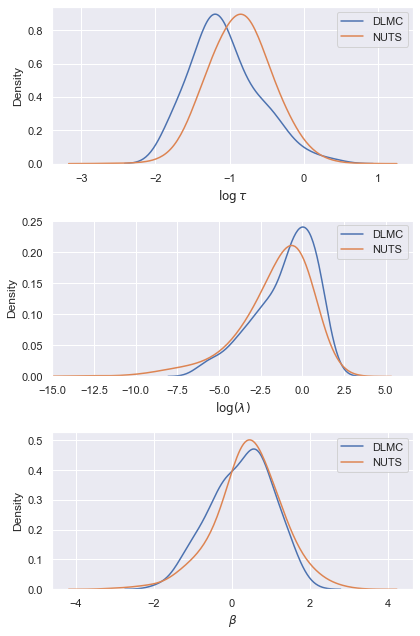

In [206]:
sub_idx = np.random.choice(np.arange(len(truth_x)), len(xf), replace=False)

sns.set_theme()
fig = plt.figure(figsize=(2 * 2 * 1.5, 2 * 1.5 * 3))
plt.subplot(3, 1, 1)
sns.kdeplot(xf[0][:, 0], label='DLMC', bw=0.4)
sns.kdeplot(np.log(truth_x[:, 0]), label='NUTS', bw=0.4)
plt.xlabel(r'$\log\tau$')
plt.legend(loc='upper right')
plt.subplot(3, 1, 2)
sns.kdeplot(xf[0][:, 10], label='DLMC', bw=0.4)
sns.kdeplot(np.log(truth_x[:, 10]), label='NUTS', bw=0.4)
plt.xlabel(r'$\log(\lambda)$')
plt.xlim(-15)
#plt.xlim(0, 3)
plt.legend(loc='upper right')
plt.subplot(3, 1, 3)
sns.kdeplot(xf[0][:, 44], label='DLMC', bw=0.4)
sns.kdeplot(truth_x[:, 44], label='NUTS', bw=0.4)
plt.xlabel(r'$\beta$')
plt.legend(loc='upper right')
plt.tight_layout()

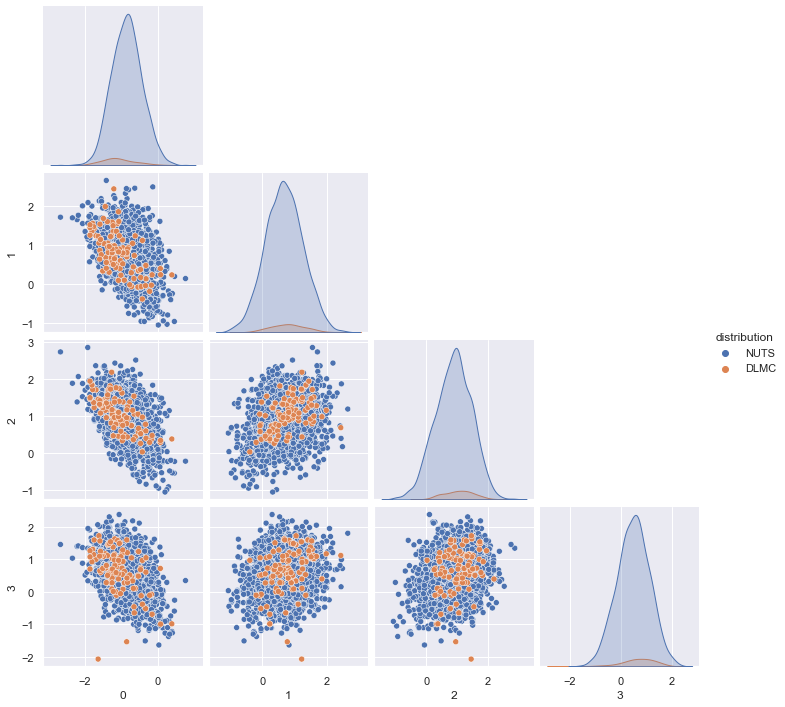

In [207]:
nuts_posterior = np.loadtxt('./fiducial_samples/german_credit_nuts_samples.txt')
log_normalized_posterior = np.copy(nuts_posterior)
log_normalized_posterior[:, :26] = np.log(log_normalized_posterior[:, :26])

df = pd.concat([
    pd.DataFrame(log_normalized_posterior[:, :4]),
    pd.DataFrame(xf[0][:, :4].numpy()),
]).reset_index(drop=True)
df['distribution'] = ['NUTS'] * len(log_normalized_posterior) + \
                     ['DLMC'] * len(xf[0])

sns.pairplot(df, corner=True, hue='distribution')

51


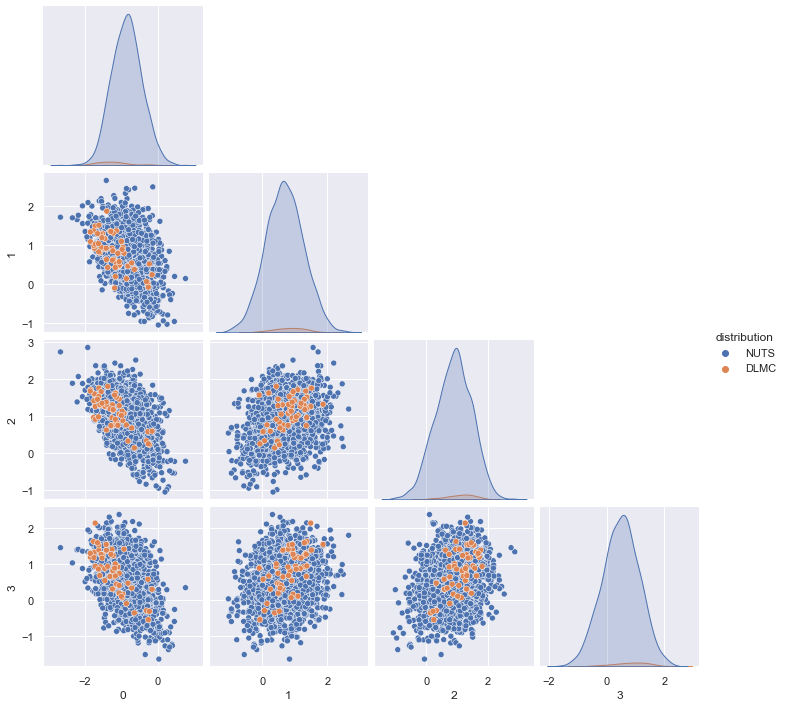

In [208]:
nuts_posterior = np.loadtxt('./fiducial_samples/german_credit_nuts_samples.txt')
log_normalized_posterior = np.copy(nuts_posterior)
log_normalized_posterior[:, :26] = np.log(log_normalized_posterior[:, :26])

samples = xf[1]['100']
print(len(xf[1]['8']))


df = pd.concat([
    pd.DataFrame(log_normalized_posterior[:, :4]),
    pd.DataFrame(samples[:, :4].numpy()),
]).reset_index(drop=True)
df['distribution'] = ['NUTS'] * len(log_normalized_posterior) + \
                     ['DLMC'] * len(samples)

sns.pairplot(df, corner=True, hue='distribution')

     labels     $x_0$     $x_1$     $x_2$     $x_3$
0         q -0.905256  0.833335  1.121208 -0.289249
1         q -1.105057  0.929908  1.369655  0.294263
2         q -0.936969  0.140220  1.259949  0.747844
3         q -1.559373  0.445084  1.303725  0.560867
4         q -1.147491  0.464959  1.092498  0.822243
...     ...       ...       ...       ...       ...
2097      T -0.877002  0.962911  0.261689 -0.048335
2098      T -0.820473  0.886644 -0.063255  0.203983
2099      T -1.080769  1.077310  0.783336  0.219806
2100      T -0.845129  0.464595  1.410720  0.672862
2101      T -0.793483  0.739946  0.692269  0.458454

[2102 rows x 5 columns]


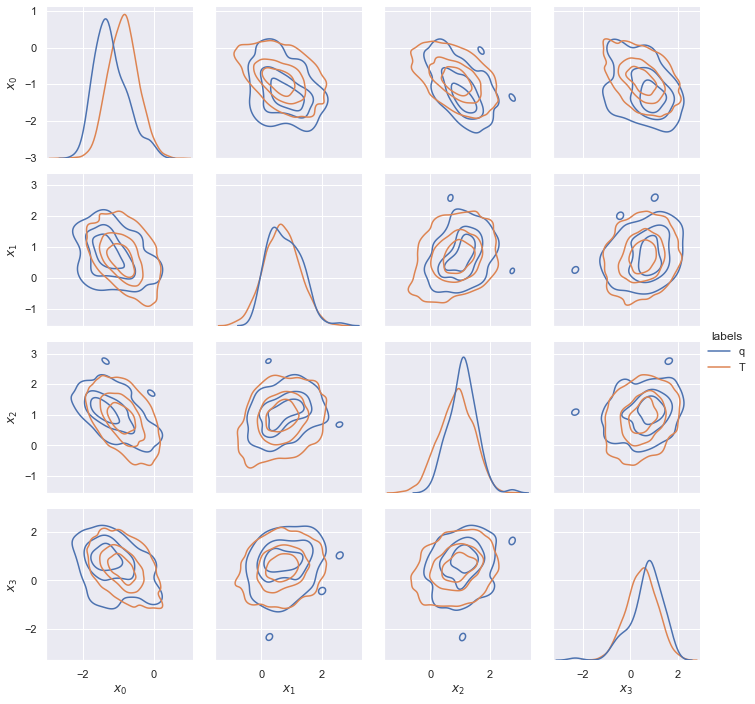

In [209]:
sns_pairplot(xf[1]['200'][:, 0:4], np.ones(len(xf[1]['200'])), log_normalized_posterior[:, :4], levels=4)

     labels     $x_0$     $x_1$     $x_2$     $x_3$
0         q  0.778345  0.705356  0.860280  1.207688
1         q -0.603456  1.662100  0.985320 -0.105610
2         q -1.095403  0.335999  1.271851  0.522841
3         q -1.577643  1.463856  0.601948  1.009209
4         q -1.609316 -1.644995  1.290167  0.133087
...     ...       ...       ...       ...       ...
2046      T -0.877002  0.962911  0.261689 -0.048335
2047      T -0.820473  0.886644 -0.063255  0.203983
2048      T -1.080769  1.077310  0.783336  0.219806
2049      T -0.845129  0.464595  1.410720  0.672862
2050      T -0.793483  0.739946  0.692269  0.458454

[2051 rows x 5 columns]


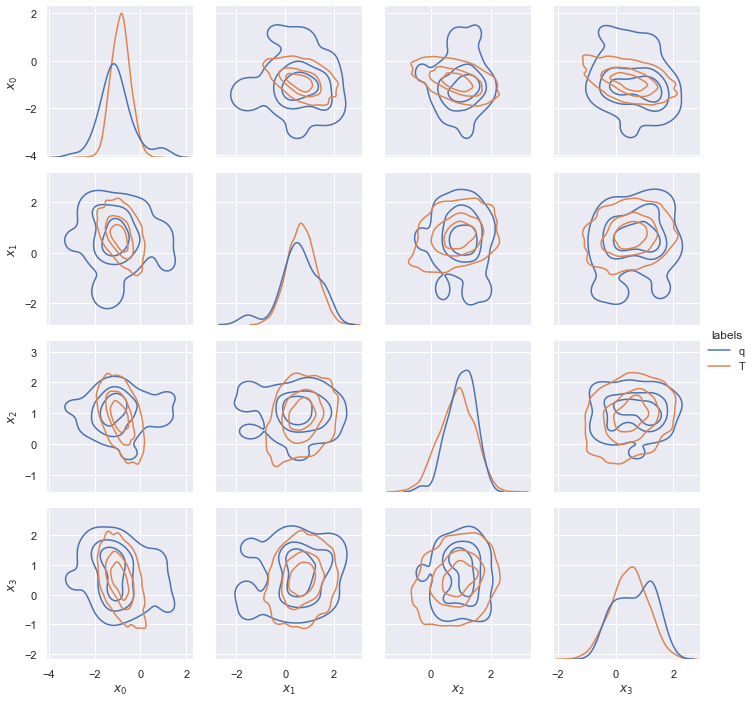

In [54]:
sns_pairplot(xf[2]['198'][:, 0:4], np.ones(len(xf[2]['58'])), log_normalized_posterior[:, :4], levels=4)

     labels     $x_0$     $x_1$     $x_2$     $x_3$
0         q -0.647011  0.729527  1.052112 -0.647936
1         q -0.956174  0.928808  1.379117  0.080937
2         q -0.547470 -0.078305  1.049463  0.507017
3         q -1.336684  0.303005  1.228507  0.296075
4         q -1.122862  0.492283  1.097137  0.769166
...     ...       ...       ...       ...       ...
2097      T -0.877002  0.962911  0.261689 -0.048335
2098      T -0.820473  0.886644 -0.063255  0.203983
2099      T -1.080769  1.077310  0.783336  0.219806
2100      T -0.845129  0.464595  1.410720  0.672862
2101      T -0.793483  0.739946  0.692269  0.458454

[2102 rows x 5 columns]


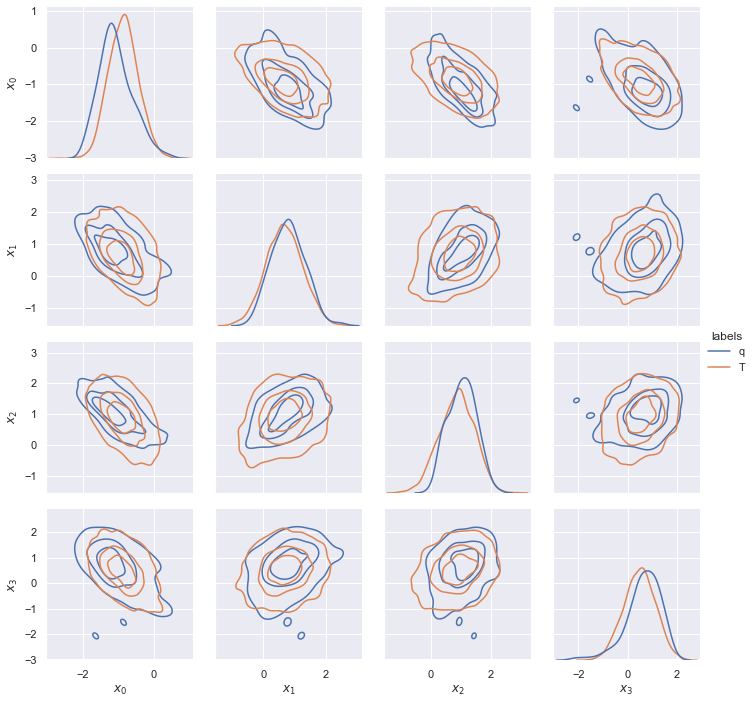

In [212]:
sns_pairplot(xf[0][:, 0:4], np.ones(len(xf[0])), log_normalized_posterior[:, 0:4], levels=4)